# Election

In [246]:
from sqlalchemy.orm import Session
from models import (
    ResultatElection, ElectionStats, Candidat, Departement, Election, PopulationDepartement, Entreprise, Menage
)
import pandas as pd
from db import SessionLocal

# Création de la session
session = SessionLocal()

# Requête pour récupérer tous les résultats avec relations
results = session.query(
    ResultatElection.id.label("resultat_id"),
    ResultatElection.nb_voix,
    ResultatElection.code_dept,
    Departement.nom_dept,
    ResultatElection.election_id,
    Election.date.label("date_election"),
    Election.type_election,
    Election.tour,
    Candidat.id.label("candidat_id"),
    Candidat.nom.label("nom_candidat"),
    Candidat.prenom.label("prenom_candidat"),
    Candidat.sexe,  # récupère l'Enum
).join(
    Candidat, ResultatElection.candidat_id == Candidat.id
).join(
    Departement, ResultatElection.code_dept == Departement.code_dept
).join(
    Election, ResultatElection.election_id == Election.id
).all()

# Conversion en DataFrame et transformation de l'Enum en string
import pandas as pd

df_resultats = pd.DataFrame([r._asdict() for r in results])
df_resultats["sexe_candidat"] = df_resultats["sexe"].apply(lambda x: x.value)  # -> "Masculin" ou "Féminin"
df_resultats.drop(columns=["sexe"], inplace=True)
df_resultats["type_election"] = df_resultats["type_election"].apply(lambda x: x.value)

# Supprimer les colonnes inutiles
df_resultats = df_resultats.drop(columns=["candidat_id", "resultat_id"])

df_resultats.head()



2026-01-18 17:19:03,294 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2026-01-18 17:19:03,307 INFO sqlalchemy.engine.Engine SELECT resultats_election.id AS resultat_id, resultats_election.nb_voix AS resultats_election_nb_voix, resultats_election.code_dept AS resultats_election_code_dept, departements.nom_dept AS departements_nom_dept, resultats_election.election_id AS resultats_election_election_id, elections.date AS date_election, elections.type_election AS elections_type_election, elections.tour AS elections_tour, candidats.id AS candidat_id, candidats.nom AS nom_candidat, candidats.prenom AS prenom_candidat, candidats.sexe AS candidats_sexe 
FROM resultats_election JOIN candidats ON resultats_election.candidat_id = candidats.id JOIN departements ON resultats_election.code_dept = departements.code_dept JOIN elections ON resultats_election.election_id = elections.id
2026-01-18 17:19:03,308 INFO sqlalchemy.engine.Engine [cached since 7696s ago] {}


,nb_voix,code_dept,nom_dept,election_id,date_election,type_election,tour,nom_candidat,prenom_candidat,sexe_candidat
0,7268,01,ain,1,2012-04-22,Présidentielle,1,JOLY,EVA,Féminin
1,3455,02,aisne,1,2012-04-22,Présidentielle,1,JOLY,EVA,Féminin
2,3232,03,allier,1,2012-04-22,Présidentielle,1,JOLY,EVA,Féminin
3,2933,04,alpes-de-haute-provence,1,2012-04-22,Présidentielle,1,JOLY,EVA,Féminin
4,3147,05,hautes-alpes,1,2012-04-22,Présidentielle,1,JOLY,EVA,Féminin


In [247]:
# Dictionnaire de mapping nom_candidat -> parti
partis = {
    'JOLY': 'EELV',
    'LE PEN': 'RN',
    'SARKOZY': 'LR',
    'MÉLENCHON': 'LFI',
    'POUTOU': 'NPA',
    'ARTHAUD': 'LO',
    'CHEMINADE': 'SP',
    'BAYROU': 'MoDem',
    'DUPONT-AIGNAN': 'DF',
    'HOLLANDE': 'PS',
    'MACRON': 'LREM',
    'FILLON': 'LR',
    'HAMON': 'PS',
    'LASSALLE': 'Résistons !',
    'ASSELINEAU': 'UPR',
    'ROUSSEL': 'PCF',
    'ZEMMOUR': 'Reconquête',
    'HIDALGO': 'PS',
    'JADOT': 'EELV',
    'PÉCRESSE': 'LR'
}

# Création de la nouvelle colonne 'parti'
df_resultats['parti'] = df_resultats['nom_candidat'].map(partis)

# Vérification
print(df_resultats.head(1600))


      nb_voix code_dept                  nom_dept  election_id date_election  \
0        7268        01                       ain            1    2012-04-22   
1        3455        02                     aisne            1    2012-04-22   
2        3232        03                    allier            1    2012-04-22   
3        2933        04   alpes-de-haute-provence            1    2012-04-22   
4        3147        05              hautes-alpes            1    2012-04-22   
...       ...       ...                       ...          ...           ...   
1595    66292        ZD                la réunion            3    2017-04-23   
1596     6403        ZM                   mayotte            3    2017-04-23   
1597    11089        ZN        nouvelle-calédonie            3    2017-04-23   
1598    11128        ZP       polynésie française            3    2017-04-23   
1599      473        ZS  saint-pierre-et-miquelon            3    2017-04-23   

       type_election  tour nom_candidat

In [248]:
from models import ElectionStats

# Requête
stats = session.query(
    ElectionStats.election_id,
    ElectionStats.code_dept,
    ElectionStats.nb_inscrits,
    ElectionStats.nb_votants,
    ElectionStats.nb_abstentions,
    ElectionStats.nb_blancs_nuls
).all()

# Conversion en DataFrame
df_stats = pd.DataFrame([s._asdict() for s in stats])
df_stats.head()


2026-01-18 17:19:03,646 INFO sqlalchemy.engine.Engine SELECT election_stats.election_id AS election_stats_election_id, election_stats.code_dept AS election_stats_code_dept, election_stats.nb_inscrits AS election_stats_nb_inscrits, election_stats.nb_votants AS election_stats_nb_votants, election_stats.nb_abstentions AS election_stats_nb_abstentions, election_stats.nb_blancs_nuls AS election_stats_nb_blancs_nuls 
FROM election_stats
2026-01-18 17:19:03,648 INFO sqlalchemy.engine.Engine [cached since 7696s ago] {}


,election_id,code_dept,nb_inscrits,nb_votants,nb_abstentions,nb_blancs_nuls
0,1,01,393808,327812,65996,6453
1,1,02,376068,303140,72928,5196
2,1,03,256275,211009,45266,5059
3,1,04,123933,102899,21034,2111
4,1,05,106865,88619,18246,1842


In [249]:
df_resultats = df_resultats.merge(
    df_stats,
    on=["election_id", "code_dept"],
    how="left"
)


df_resultats.head()

,nb_voix,code_dept,nom_dept,election_id,date_election,type_election,tour,nom_candidat,prenom_candidat,sexe_candidat,parti,nb_inscrits,nb_votants,nb_abstentions,nb_blancs_nuls
0,7268,01,ain,1,2012-04-22,Présidentielle,1,JOLY,EVA,Féminin,EELV,393808,327812,65996,6453
1,3455,02,aisne,1,2012-04-22,Présidentielle,1,JOLY,EVA,Féminin,EELV,376068,303140,72928,5196
2,3232,03,allier,1,2012-04-22,Présidentielle,1,JOLY,EVA,Féminin,EELV,256275,211009,45266,5059
3,2933,04,alpes-de-haute-provence,1,2012-04-22,Présidentielle,1,JOLY,EVA,Féminin,EELV,123933,102899,21034,2111
4,3147,05,hautes-alpes,1,2012-04-22,Présidentielle,1,JOLY,EVA,Féminin,EELV,106865,88619,18246,1842


In [250]:
# Calcul du pourcentage de voix sur le nombre de votants
df_resultats['pct_voix'] = (df_resultats['nb_voix'] / df_resultats['nb_votants']) * 100

# Arrondi à 2 décimales si tu veux
df_resultats['pct_voix'] = df_resultats['pct_voix'].round(2)

# Vérification
print(df_resultats.head(1000))

     nb_voix code_dept                 nom_dept  election_id date_election  \
0       7268        01                      ain            1    2012-04-22   
1       3455        02                    aisne            1    2012-04-22   
2       3232        03                   allier            1    2012-04-22   
3       2933        04  alpes-de-haute-provence            1    2012-04-22   
4       3147        05             hautes-alpes            1    2012-04-22   
..       ...       ...                      ...          ...           ...   
995    38446        32                     gers            1    2012-04-22   
996   260043        33                  gironde            1    2012-04-22   
997   160931        34                  hérault            1    2012-04-22   
998   183935        35          ille-et-vilaine            1    2012-04-22   
999    41505        36                    indre            1    2012-04-22   

      type_election  tour nom_candidat prenom_candidat sexe_can

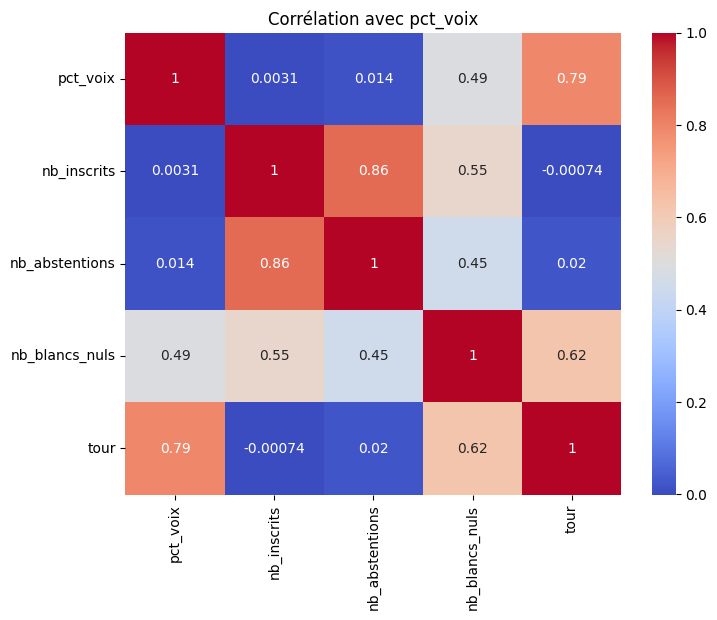

In [251]:
import seaborn as sns
import matplotlib.pyplot as plt

num_cols = [
    'pct_voix',
    'nb_inscrits',
    'nb_abstentions',
    'nb_blancs_nuls',
    'tour'
]

corr = df_resultats[num_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Corrélation avec pct_voix")
plt.show()


In [252]:
features = [
    'nb_inscrits',
    'nb_abstentions',
    'nb_blancs_nuls',
    'tour'
]


In [253]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

X = df_resultats[features].dropna()

vif_df = pd.DataFrame()
vif_df['variable'] = X.columns
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_df.sort_values('VIF', ascending=False))


         variable        VIF
0     nb_inscrits  10.380959
1  nb_abstentions   7.996179
2  nb_blancs_nuls   3.124338
3            tour   2.962254


In [254]:
# S'assurer que la colonne est bien au format datetime
df_resultats['date_election'] = pd.to_datetime(df_resultats['date_election'])

# Extraire uniquement l'année
df_resultats['annee'] = df_resultats['date_election'].dt.year


In [255]:
import pandas as pd

# Fusionner prénom et nom en une seule colonne nom_candidat
df_resultats['nom_candidat'] = df_resultats['prenom_candidat'] + ' ' + df_resultats['nom_candidat']



In [256]:
df_resultats['pct_abstentions'] = df_resultats['nb_abstentions'] / df_resultats['nb_votants'] * 100
df_resultats['pct_blancs_nuls'] = df_resultats['nb_blancs_nuls'] / df_resultats['nb_votants'] * 100


In [257]:
colonnes_a_supprimer = [
    "nom_dept",
    "election_id",
    "prenom_candidat",
    "type_election",
    "sexe_candidat",
    'nb_votants',
    'nb_voix',
    'nb_inscrits',
    'date_election',
    'nb_abstentions',
    'nb_blancs_nuls'
]

df_resultats = df_resultats.drop(columns=colonnes_a_supprimer)


In [258]:
# Vérification
print(df_resultats.head(60))

   code_dept  tour nom_candidat parti  pct_voix  annee  pct_abstentions  \
0         01     1     EVA JOLY  EELV      2.22   2012        20.132271   
1         02     1     EVA JOLY  EELV      1.14   2012        24.057531   
2         03     1     EVA JOLY  EELV      1.53   2012        21.452166   
3         04     1     EVA JOLY  EELV      2.85   2012        20.441404   
4         05     1     EVA JOLY  EELV      3.55   2012        20.589264   
5         06     1     EVA JOLY  EELV      2.12   2012        25.913449   
6         07     1     EVA JOLY  EELV      2.74   2012        18.828952   
7         08     1     EVA JOLY  EELV      1.20   2012        25.954854   
8         09     1     EVA JOLY  EELV      2.80   2012        18.905056   
9         10     1     EVA JOLY  EELV      1.38   2012        22.902971   
10        11     1     EVA JOLY  EELV      2.05   2012        19.778651   
11        12     1     EVA JOLY  EELV      2.28   2012        17.232030   
12        13     1     EV

In [259]:
import pandas as pd

df_pivot = df_resultats.pivot_table(
    index=['code_dept', 'tour', 'annee', 'pct_abstentions', 'pct_blancs_nuls'],  # ce qui définit une ligne
    columns='parti',                        # une colonne par parti
    values='pct_voix',                      # la valeur à mettre dans les cellules
    fill_value=0                             # mettre 0 si un parti n’a pas de voix dans ce département
).reset_index()


In [260]:
df_resultats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4160 entries, 0 to 4159
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   code_dept        4160 non-null   object 
 1   tour             4160 non-null   int64  
 2   nom_candidat     4160 non-null   object 
 3   parti            4160 non-null   object 
 4   pct_voix         4160 non-null   float64
 5   annee            4160 non-null   int32  
 6   pct_abstentions  4160 non-null   float64
 7   pct_blancs_nuls  4160 non-null   float64
dtypes: float64(3), int32(1), int64(1), object(3)
memory usage: 243.9+ KB


In [261]:
df_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   code_dept        640 non-null    object 
 1   tour             640 non-null    int64  
 2   annee            640 non-null    int32  
 3   pct_abstentions  640 non-null    float64
 4   pct_blancs_nuls  640 non-null    float64
 5   DF               640 non-null    float64
 6   EELV             640 non-null    float64
 7   LFI              640 non-null    float64
 8   LO               640 non-null    float64
 9   LR               640 non-null    float64
 10  LREM             640 non-null    float64
 11  MoDem            640 non-null    float64
 12  NPA              640 non-null    float64
 13  PCF              640 non-null    float64
 14  PS               640 non-null    float64
 15  RN               640 non-null    float64
 16  Reconquête       640 non-null    float64
 17  Résistons !     

# PopulationDepartement

In [262]:
# Fusion avec PopulationDepartement
df_pop = pd.read_sql(session.query(PopulationDepartement).statement, session.bind)

2026-01-18 17:19:04,253 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2026-01-18 17:19:04,255 INFO sqlalchemy.engine.Engine SELECT pg_catalog.pg_class.relname 
FROM pg_catalog.pg_class JOIN pg_catalog.pg_namespace ON pg_catalog.pg_namespace.oid = pg_catalog.pg_class.relnamespace 
WHERE pg_catalog.pg_class.relname = %(table_name)s AND pg_catalog.pg_class.relkind = ANY (ARRAY[%(param_1)s, %(param_2)s, %(param_3)s, %(param_4)s, %(param_5)s]) AND pg_catalog.pg_table_is_visible(pg_catalog.pg_class.oid) AND pg_catalog.pg_namespace.nspname != %(nspname_1)s
2026-01-18 17:19:04,255 INFO sqlalchemy.engine.Engine [cached since 7693s ago] {'table_name': <sqlalchemy.sql.selectable.Select object at 0xfffef6444210>, 'param_1': 'r', 'param_2': 'p', 'param_3': 'f', 'param_4': 'v', 'param_5': 'm', 'nspname_1': 'pg_catalog'}
2026-01-18 17:19:04,257 INFO sqlalchemy.engine.Engine SELECT population_departement.id, population_departement.departement_code, population_departement.sexe_id, population_departeme

In [263]:
df_pop = df_pop.rename(columns={
    "departement_code": "code_dept"
})
df_pop.head(10)


,id,code_dept,sexe_id,tranche_age_id,annee,population
0,1,ZA,2,1,2007,63118
1,2,ZA,2,2,2007,44730
2,3,ZA,2,3,2007,51025
3,4,ZA,2,4,2007,20686
4,5,ZA,2,5,2007,8766
5,6,ZB,2,1,2007,57391
6,7,ZB,2,2,2007,44191
7,8,ZB,2,3,2007,51680
8,9,ZB,2,4,2007,22116
9,10,ZB,2,5,2007,9592


In [264]:
df_pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15770 entries, 0 to 15769
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              15770 non-null  int64 
 1   code_dept       15770 non-null  object
 2   sexe_id         15770 non-null  int64 
 3   tranche_age_id  15770 non-null  int64 
 4   annee           15770 non-null  int64 
 5   population      15770 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 739.3+ KB


### Agrégation

In [265]:
# Population totale par département / année
pop_total = (
    df_pop
    .groupby(['code_dept', 'annee'])['population']
    .sum()
    .reset_index(name='population_totale')
)


In [266]:
print(pop_total.head(10))

  code_dept  annee  population_totale
0        01   2007             574377
1        01   2008             581355
2        01   2009             588853
3        01   2010             597341
4        01   2011             603827
5        01   2012             612191
6        01   2013             619497
7        01   2014             626127
8        01   2015             631877
9        01   2016             638425


### Répartition par sexe (%)

In [267]:
pop_sexe = (
    df_pop
    .groupby(['code_dept', 'annee', 'sexe_id'])['population']
    .sum()
    .unstack(fill_value=0)
    .reset_index()
)

pop_sexe['pct_hommes'] = pop_sexe[2] / (pop_sexe[2] + pop_sexe[3])
pop_sexe['pct_femmes'] = pop_sexe[3] / (pop_sexe[2] + pop_sexe[3])

pop_sexe = pop_sexe[['code_dept', 'annee', 'pct_hommes', 'pct_femmes']]

In [268]:
print(pop_sexe.head(10))

sexe_id code_dept  annee  pct_hommes  pct_femmes
0              01   2007    0.494015    0.505985
1              01   2008    0.494077    0.505923
2              01   2009    0.493948    0.506052
3              01   2010    0.495039    0.504961
4              01   2011    0.494945    0.505055
5              01   2012    0.494663    0.505337
6              01   2013    0.494317    0.505683
7              01   2014    0.494861    0.505139
8              01   2015    0.493738    0.506262
9              01   2016    0.493312    0.506688


### Repartion par age  (%)

In [269]:
pop_age = (
    df_pop
    .groupby(['code_dept', 'annee', 'tranche_age_id'])['population']
    .sum()
    .unstack(fill_value=0)
    .reset_index()
)

pop_age['pct_jeunes'] = (pop_age[1] + pop_age[2]) / pop_age[[1,2,3,4,5]].sum(axis=1)
pop_age['pct_seniors'] = (pop_age[4] + pop_age[5]) / pop_age[[1,2,3,4,5]].sum(axis=1)

pop_age = pop_age[['code_dept', 'annee', 'pct_jeunes', 'pct_seniors']]


In [270]:
print(pop_age.head(10))

tranche_age_id code_dept  annee  pct_jeunes  pct_seniors
0                     01   2007    0.524051     0.192158
1                     01   2008    0.519806     0.196670
2                     01   2009    0.516443     0.201008
3                     01   2010    0.513683     0.204481
4                     01   2011    0.510713     0.209151
5                     01   2012    0.506162     0.213046
6                     01   2013    0.501975     0.216109
7                     01   2014    0.497640     0.219967
8                     01   2015    0.495302     0.223575
9                     01   2016    0.494306     0.226792


### Indice de vieillissement

In [271]:
pop_age['indice_vieillissement'] = (
    (pop_age['pct_seniors']) /
    (pop_age['pct_jeunes'] + 1e-6)
)


### Fusion finale

In [272]:
df_demo = (
    pop_total
    .merge(pop_sexe, on=['code_dept', 'annee'])
    .merge(pop_age, on=['code_dept', 'annee'])
)

print(df_demo.head())
df_demo.info()

  code_dept  annee  population_totale  pct_hommes  pct_femmes  pct_jeunes  \
0        01   2007             574377    0.494015    0.505985    0.524051   
1        01   2008             581355    0.494077    0.505923    0.519806   
2        01   2009             588853    0.493948    0.506052    0.516443   
3        01   2010             597341    0.495039    0.504961    0.513683   
4        01   2011             603827    0.494945    0.505055    0.510713   

   pct_seniors  indice_vieillissement  
0     0.192158               0.366677  
1     0.196670               0.378351  
2     0.201008               0.389215  
3     0.204481               0.398068  
4     0.209151               0.409527  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1577 entries, 0 to 1576
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   code_dept              1577 non-null   object 
 1   annee                  1577 no

In [273]:
df_pivot_pop = df_demo.merge(
    df_pivot,
    on=['code_dept', 'annee'],
    how='inner'  # ou 'inner' si tu veux seulement les lignes communes
)

In [274]:
print(df_pivot_pop.shape)
df_pivot_pop.head()

(592, 26)


,code_dept,annee,population_totale,pct_hommes,pct_femmes,pct_jeunes,pct_seniors,indice_vieillissement,tour,pct_abstentions,...,LREM,MoDem,NPA,PCF,PS,RN,Reconquête,Résistons !,SP,UPR
0,01,2012,612191,0.494663,0.505337,0.506162,0.213046,0.420904,1,20.132271,...,0.00,9.96,1.01,0.00,22.30,20.30,0.00,0.00,0.26,0.00
1,01,2012,612191,0.494663,0.505337,0.506162,0.213046,0.420904,2,20.600636,...,0.00,0.00,0.00,0.00,40.21,0.00,0.00,0.00,0.00,0.00
2,01,2017,643350,0.493187,0.506813,0.492116,0.230438,0.468257,1,24.382512,...,22.04,0.00,0.93,0.00,5.00,24.36,0.00,1.04,0.18,1.08
3,01,2017,643350,0.493187,0.506813,0.492116,0.230438,0.468257,2,28.850711,...,53.85,0.00,0.00,0.00,0.00,34.51,0.00,0.00,0.00,0.00
4,01,2022,668613,0.493661,0.506339,0.480215,0.246774,0.513880,1,28.640683,...,27.07,0.00,0.64,1.74,1.66,25.47,8.08,3.19,0.00,0.00


# Chomage

In [275]:
from models import Chomage

# Récupération de toutes les données de chômage
df_chomage = pd.read_sql(session.query(Chomage).statement, session.bind)


2026-01-18 17:19:04,594 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2026-01-18 17:19:04,595 INFO sqlalchemy.engine.Engine SELECT pg_catalog.pg_class.relname 
FROM pg_catalog.pg_class JOIN pg_catalog.pg_namespace ON pg_catalog.pg_namespace.oid = pg_catalog.pg_class.relnamespace 
WHERE pg_catalog.pg_class.relname = %(table_name)s AND pg_catalog.pg_class.relkind = ANY (ARRAY[%(param_1)s, %(param_2)s, %(param_3)s, %(param_4)s, %(param_5)s]) AND pg_catalog.pg_table_is_visible(pg_catalog.pg_class.oid) AND pg_catalog.pg_namespace.nspname != %(nspname_1)s
2026-01-18 17:19:04,596 INFO sqlalchemy.engine.Engine [cached since 7693s ago] {'table_name': <sqlalchemy.sql.selectable.Select object at 0xffff0c50e210>, 'param_1': 'r', 'param_2': 'p', 'param_3': 'f', 'param_4': 'v', 'param_5': 'm', 'nspname_1': 'pg_catalog'}
2026-01-18 17:19:04,598 INFO sqlalchemy.engine.Engine SELECT chomage.code_dept, chomage.annee, chomage.trimestre, chomage.taux_chomage 
FROM chomage
2026-01-18 17:19:04,599 INFO sql

In [276]:
df_chomage_annuel = df_chomage.groupby(
    ['code_dept', 'annee']
).agg({
    'taux_chomage': 'mean',
}).reset_index()

# Exemple de visualisation
df_chomage_annuel.head(60)


,code_dept,annee,taux_chomage
0,01,2007,4.925
1,01,2008,4.800
2,01,2009,6.875
3,01,2010,6.750
4,01,2011,6.325
5,01,2012,6.850
6,01,2013,7.200
7,01,2014,7.075
8,01,2015,7.350
9,01,2016,7.350


In [277]:
df_chomage_annuel.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   code_dept     1600 non-null   object 
 1   annee         1600 non-null   int64  
 2   taux_chomage  1572 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 37.6+ KB


In [278]:
# Vérification des types
df_chomage_annuel['annee'] = df_chomage_annuel['annee'].astype(int)
df_pivot_pop['annee'] = df_pivot_pop['annee'].astype(int)

# Merge
df_pivot_pop = df_pivot_pop.merge(
    df_chomage_annuel,
    on=['code_dept', 'annee'],
    how='left'
)


In [279]:
df_pivot_pop.info()
df_pivot_pop.head(60)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 592 entries, 0 to 591
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   code_dept              592 non-null    object 
 1   annee                  592 non-null    int64  
 2   population_totale      592 non-null    int64  
 3   pct_hommes             592 non-null    float64
 4   pct_femmes             592 non-null    float64
 5   pct_jeunes             592 non-null    float64
 6   pct_seniors            592 non-null    float64
 7   indice_vieillissement  592 non-null    float64
 8   tour                   592 non-null    int64  
 9   pct_abstentions        592 non-null    float64
 10  pct_blancs_nuls        592 non-null    float64
 11  DF                     592 non-null    float64
 12  EELV                   592 non-null    float64
 13  LFI                    592 non-null    float64
 14  LO                     592 non-null    float64
 15  LR    

,code_dept,annee,population_totale,pct_hommes,pct_femmes,pct_jeunes,pct_seniors,indice_vieillissement,tour,pct_abstentions,...,MoDem,NPA,PCF,PS,RN,Reconquête,Résistons !,SP,UPR,taux_chomage
0,01,2012,612191,0.494663,0.505337,0.506162,0.213046,0.420904,1,20.132271,...,9.96,1.01,0.00,22.30,20.30,0.00,0.00,0.26,0.00,6.850
1,01,2012,612191,0.494663,0.505337,0.506162,0.213046,0.420904,2,20.600636,...,0.00,0.00,0.00,40.21,0.00,0.00,0.00,0.00,0.00,6.850
2,01,2017,643350,0.493187,0.506813,0.492116,0.230438,0.468257,1,24.382512,...,0.00,0.93,0.00,5.00,24.36,0.00,1.04,0.18,1.08,6.750
3,01,2017,643350,0.493187,0.506813,0.492116,0.230438,0.468257,2,28.850711,...,0.00,0.00,0.00,0.00,34.51,0.00,0.00,0.00,0.00,6.750
4,01,2022,668613,0.493661,0.506339,0.480215,0.246774,0.513880,1,28.640683,...,0.00,0.64,1.74,1.66,25.47,8.08,3.19,0.00,0.00,5.400
5,01,2022,668613,0.493661,0.506339,0.480215,0.246774,0.513880,2,33.335564,...,0.00,0.00,0.00,0.00,41.49,0.00,0.00,0.00,0.00,5.400
6,02,2012,540888,0.486705,0.513295,0.489676,0.235134,0.480181,1,24.057531,...,6.56,1.27,0.00,26.64,25.88,0.00,0.00,0.24,0.00,13.675
7,02,2012,540888,0.486705,0.513295,0.489676,0.235134,0.480181,2,24.496153,...,0.00,0.00,0.00,48.75,0.00,0.00,0.00,0.00,0.00,13.675
8,02,2017,534490,0.487697,0.512303,0.472785,0.262613,0.555458,1,27.128352,...,0.00,1.07,0.00,4.14,34.78,0.00,0.77,0.18,0.73,12.975
9,02,2017,534490,0.487697,0.512303,0.472785,0.262613,0.555458,2,31.835213,...,0.00,0.00,0.00,0.00,46.99,0.00,0.00,0.00,0.00,12.975


In [280]:
# Calcul de la moyenne (en ignorant automatiquement les NaN)
moyenne_chomage = df_pivot_pop["taux_chomage"].mean()

# Remplacement des valeurs manquantes par la moyenne
df_pivot_pop["taux_chomage"] = df_pivot_pop["taux_chomage"].fillna(moyenne_chomage)

In [281]:
df_pivot_pop.isna().sum().sort_values(ascending=False)

code_dept                0
LO                       0
UPR                      0
SP                       0
Résistons !              0
Reconquête               0
RN                       0
PS                       0
PCF                      0
NPA                      0
MoDem                    0
LREM                     0
LR                       0
LFI                      0
annee                    0
EELV                     0
DF                       0
pct_blancs_nuls          0
pct_abstentions          0
tour                     0
indice_vieillissement    0
pct_seniors              0
pct_jeunes               0
pct_femmes               0
pct_hommes               0
population_totale        0
taux_chomage             0
dtype: int64

# Securité

In [282]:
from models import FaitSecurite, Indicateur, UniteDeCompte

# Charger les faits de sécurité
df_securite = pd.read_sql(session.query(FaitSecurite).statement, session.bind)
# Récupérer libellés indicateurs et unités de compte
df_indicateur = pd.read_sql(session.query(Indicateur).statement, session.bind)
df_unite = pd.read_sql(session.query(UniteDeCompte).statement, session.bind)

# Fusion pour avoir les noms
df_securite = df_securite.merge(df_indicateur, left_on='indicateur_id', right_on='id', how='left', suffixes=('', '_ind'))
df_securite = df_securite.merge(df_unite, left_on='unite_de_compte_id', right_on='id', how='left', suffixes=('', '_unite'))

# On ne garde que l'essentiel
df_securite = df_securite[['departement_code', 'annee', 'libelle', 'libelle_unite', 'nombre', 'taux_pour_mille']]


2026-01-18 17:19:05,940 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2026-01-18 17:19:05,943 INFO sqlalchemy.engine.Engine SELECT pg_catalog.pg_class.relname 
FROM pg_catalog.pg_class JOIN pg_catalog.pg_namespace ON pg_catalog.pg_namespace.oid = pg_catalog.pg_class.relnamespace 
WHERE pg_catalog.pg_class.relname = %(table_name)s AND pg_catalog.pg_class.relkind = ANY (ARRAY[%(param_1)s, %(param_2)s, %(param_3)s, %(param_4)s, %(param_5)s]) AND pg_catalog.pg_table_is_visible(pg_catalog.pg_class.oid) AND pg_catalog.pg_namespace.nspname != %(nspname_1)s
2026-01-18 17:19:05,944 INFO sqlalchemy.engine.Engine [cached since 7694s ago] {'table_name': <sqlalchemy.sql.selectable.Select object at 0xffff0c06e950>, 'param_1': 'r', 'param_2': 'p', 'param_3': 'f', 'param_4': 'v', 'param_5': 'm', 'nspname_1': 'pg_catalog'}
2026-01-18 17:19:05,946 INFO sqlalchemy.engine.Engine SELECT fait_securite.id, fait_securite.nombre, fait_securite.taux_pour_mille, fait_securite.annee, fait_securite.indicateur_id,

In [283]:
df_securite = df_securite.rename(columns={
    "departement_code": "code_dept"
})

In [284]:
# On peut voir les colonnes principales
df_securite.head(60)

,code_dept,annee,libelle,libelle_unite,nombre,taux_pour_mille
0,10,2016,Homicides,Victime,6,0.019423
1,11,2016,Homicides,Victime,2,0.005434
2,12,2016,Homicides,Victime,1,0.003588
3,13,2016,Homicides,Victime,44,0.021785
4,14,2016,Homicides,Victime,4,0.005766
5,15,2016,Homicides,Victime,2,0.013702
6,16,2016,Homicides,Victime,5,0.014153
7,17,2016,Homicides,Victime,8,0.012457
8,18,2016,Homicides,Victime,4,0.013025
9,19,2016,Homicides,Victime,1,0.004140


In [285]:
# Par exemple, moyenne ou somme selon ce que tu veux
df_securite_agg = df_securite.groupby(['code_dept', 'annee']).agg({
    'taux_pour_mille': 'sum'
}).reset_index()

In [286]:
# Merge
df_pivot_pop = df_pivot_pop.merge(
    df_securite_agg,
    on=['code_dept', 'annee'],
    how='left'
)

In [287]:

df_pivot_pop.head(60)

,code_dept,annee,population_totale,pct_hommes,pct_femmes,pct_jeunes,pct_seniors,indice_vieillissement,tour,pct_abstentions,...,NPA,PCF,PS,RN,Reconquête,Résistons !,SP,UPR,taux_chomage,taux_pour_mille
0,01,2012,612191,0.494663,0.505337,0.506162,0.213046,0.420904,1,20.132271,...,1.01,0.00,22.30,20.30,0.00,0.00,0.26,0.00,6.850,NaN
1,01,2012,612191,0.494663,0.505337,0.506162,0.213046,0.420904,2,20.600636,...,0.00,0.00,40.21,0.00,0.00,0.00,0.00,0.00,6.850,NaN
2,01,2017,643350,0.493187,0.506813,0.492116,0.230438,0.468257,1,24.382512,...,0.93,0.00,5.00,24.36,0.00,1.04,0.18,1.08,6.750,36.113905
3,01,2017,643350,0.493187,0.506813,0.492116,0.230438,0.468257,2,28.850711,...,0.00,0.00,0.00,34.51,0.00,0.00,0.00,0.00,6.750,36.113905
4,01,2022,668613,0.493661,0.506339,0.480215,0.246774,0.513880,1,28.640683,...,0.64,1.74,1.66,25.47,8.08,3.19,0.00,0.00,5.400,40.539262
5,01,2022,668613,0.493661,0.506339,0.480215,0.246774,0.513880,2,33.335564,...,0.00,0.00,0.00,41.49,0.00,0.00,0.00,0.00,5.400,40.539262
6,02,2012,540888,0.486705,0.513295,0.489676,0.235134,0.480181,1,24.057531,...,1.27,0.00,26.64,25.88,0.00,0.00,0.24,0.00,13.675,NaN
7,02,2012,540888,0.486705,0.513295,0.489676,0.235134,0.480181,2,24.496153,...,0.00,0.00,48.75,0.00,0.00,0.00,0.00,0.00,13.675,NaN
8,02,2017,534490,0.487697,0.512303,0.472785,0.262613,0.555458,1,27.128352,...,1.07,0.00,4.14,34.78,0.00,0.77,0.18,0.73,12.975,41.059615
9,02,2017,534490,0.487697,0.512303,0.472785,0.262613,0.555458,2,31.835213,...,0.00,0.00,0.00,46.99,0.00,0.00,0.00,0.00,12.975,41.059615


In [288]:
# Calcul de la moyenne (en ignorant automatiquement les NaN)
moyenne_chomage = df_pivot_pop["taux_pour_mille"].mean()

# Remplacement des valeurs manquantes par la moyenne
df_pivot_pop["taux_pour_mille"] = df_pivot_pop["taux_pour_mille"].fillna(moyenne_chomage)

In [289]:
df_pivot_pop.isna().sum().sort_values(ascending=False)

code_dept                0
annee                    0
taux_chomage             0
UPR                      0
SP                       0
Résistons !              0
Reconquête               0
RN                       0
PS                       0
PCF                      0
NPA                      0
MoDem                    0
LREM                     0
LR                       0
LO                       0
LFI                      0
EELV                     0
DF                       0
pct_blancs_nuls          0
pct_abstentions          0
tour                     0
indice_vieillissement    0
pct_seniors              0
pct_jeunes               0
pct_femmes               0
pct_hommes               0
population_totale        0
taux_pour_mille          0
dtype: int64

# Entreprise

In [290]:
df_entreprise = pd.read_sql(session.query(Entreprise).statement, session.bind)
df_entreprise.head()

2026-01-18 17:19:06,247 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2026-01-18 17:19:06,247 INFO sqlalchemy.engine.Engine SELECT pg_catalog.pg_class.relname 
FROM pg_catalog.pg_class JOIN pg_catalog.pg_namespace ON pg_catalog.pg_namespace.oid = pg_catalog.pg_class.relnamespace 
WHERE pg_catalog.pg_class.relname = %(table_name)s AND pg_catalog.pg_class.relkind = ANY (ARRAY[%(param_1)s, %(param_2)s, %(param_3)s, %(param_4)s, %(param_5)s]) AND pg_catalog.pg_table_is_visible(pg_catalog.pg_class.oid) AND pg_catalog.pg_namespace.nspname != %(nspname_1)s
2026-01-18 17:19:06,248 INFO sqlalchemy.engine.Engine [cached since 7695s ago] {'table_name': <sqlalchemy.sql.selectable.Select object at 0xfffef5cbee90>, 'param_1': 'r', 'param_2': 'p', 'param_3': 'f', 'param_4': 'v', 'param_5': 'm', 'nspname_1': 'pg_catalog'}
2026-01-18 17:19:06,248 INFO sqlalchemy.engine.Engine SELECT entreprise_contexte.id, entreprise_contexte.annee, entreprise_contexte.croissance_total_entreprises, entreprise_contexte

,id,annee,croissance_total_entreprises,ratio_micro,solde_commercial,croissance_export
0,1,2007,0.103639,0.000000,-0.435477,-0.002395
1,2,2008,0.086014,0.000000,-0.781709,0.011799
2,3,2009,0.348594,0.380024,-0.437226,-0.113637
3,4,2010,0.297874,0.558755,-0.934584,0.075173
4,5,2011,-0.088598,0.517352,-1.527927,0.061537


In [291]:
df_pivot_pop.isna().sum().sort_values(ascending=False)

code_dept                0
annee                    0
taux_chomage             0
UPR                      0
SP                       0
Résistons !              0
Reconquête               0
RN                       0
PS                       0
PCF                      0
NPA                      0
MoDem                    0
LREM                     0
LR                       0
LO                       0
LFI                      0
EELV                     0
DF                       0
pct_blancs_nuls          0
pct_abstentions          0
tour                     0
indice_vieillissement    0
pct_seniors              0
pct_jeunes               0
pct_femmes               0
pct_hommes               0
population_totale        0
taux_pour_mille          0
dtype: int64

In [292]:
# On ne garde que les colonnes utiles pour le merge
df_eco_subset = df_entreprise[['annee', 'croissance_total_entreprises', 'solde_commercial']]

# Merge sur la colonne 'annee'
df_pivot_pop = df_pivot_pop.merge(df_eco_subset, on='annee', how='left')

# Vérification
print(df_pivot_pop.head())

  code_dept  annee  population_totale  pct_hommes  pct_femmes  pct_jeunes  \
0        01   2012             612191    0.494663    0.505337    0.506162   
1        01   2012             612191    0.494663    0.505337    0.506162   
2        01   2017             643350    0.493187    0.506813    0.492116   
3        01   2017             643350    0.493187    0.506813    0.492116   
4        01   2022             668613    0.493661    0.506339    0.480215   

   pct_seniors  indice_vieillissement  tour  pct_abstentions  ...     PS  \
0     0.213046               0.420904     1        20.132271  ...  22.30   
1     0.213046               0.420904     2        20.600636  ...  40.21   
2     0.230438               0.468257     1        24.382512  ...   5.00   
3     0.230438               0.468257     2        28.850711  ...   0.00   
4     0.246774               0.513880     1        28.640683  ...   1.66   

      RN  Reconquête  Résistons !    SP   UPR  taux_chomage  taux_pour_mille  \


# Immigration

In [300]:
from models import Immigration

# Charger les données d'immigration
df_immigration = pd.read_sql(session.query(Immigration).statement, session.bind)

# Visualiser
df_immigration.head()

2026-01-18 17:35:53,990 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2026-01-18 17:35:53,995 INFO sqlalchemy.engine.Engine SELECT pg_catalog.pg_class.relname 
FROM pg_catalog.pg_class JOIN pg_catalog.pg_namespace ON pg_catalog.pg_namespace.oid = pg_catalog.pg_class.relnamespace 
WHERE pg_catalog.pg_class.relname = %(table_name)s AND pg_catalog.pg_class.relkind = ANY (ARRAY[%(param_1)s, %(param_2)s, %(param_3)s, %(param_4)s, %(param_5)s]) AND pg_catalog.pg_table_is_visible(pg_catalog.pg_class.oid) AND pg_catalog.pg_namespace.nspname != %(nspname_1)s
2026-01-18 17:35:53,997 INFO sqlalchemy.engine.Engine [cached since 8702s ago] {'table_name': <sqlalchemy.sql.selectable.Select object at 0xfffef5bc7c50>, 'param_1': 'r', 'param_2': 'p', 'param_3': 'f', 'param_4': 'v', 'param_5': 'm', 'nspname_1': 'pg_catalog'}
2026-01-18 17:35:54,004 INFO sqlalchemy.engine.Engine SELECT immigration.id, immigration.annee, immigration.pct_immigration 
FROM immigration
2026-01-18 17:35:54,004 INFO sqlalchemy

,id,annee,pct_immigration
0,1,2022,10.327769
1,2,2021,10.200000
2,3,2020,10.200000
3,4,2019,10.000000
4,5,2018,9.800000


In [ ]:
# Fusionner df_menage dans df_pivot_pop sur 'annee'
df_pivot_pop = df_pivot_pop.merge(
    df_immigration[['pct_immigration']],
    on='annee',
    how='left'  # left pour garder toutes les lignes de df_pivot_pop
)

# Menage

In [293]:
df_menage = pd.read_sql(session.query(Menage).statement, session.bind)
df_menage.head()

2026-01-18 17:19:06,331 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2026-01-18 17:19:06,333 INFO sqlalchemy.engine.Engine SELECT pg_catalog.pg_class.relname 
FROM pg_catalog.pg_class JOIN pg_catalog.pg_namespace ON pg_catalog.pg_namespace.oid = pg_catalog.pg_class.relnamespace 
WHERE pg_catalog.pg_class.relname = %(table_name)s AND pg_catalog.pg_class.relkind = ANY (ARRAY[%(param_1)s, %(param_2)s, %(param_3)s, %(param_4)s, %(param_5)s]) AND pg_catalog.pg_table_is_visible(pg_catalog.pg_class.oid) AND pg_catalog.pg_namespace.nspname != %(nspname_1)s
2026-01-18 17:19:06,334 INFO sqlalchemy.engine.Engine [cached since 7695s ago] {'table_name': <sqlalchemy.sql.selectable.Select object at 0xfffef5cbc7d0>, 'param_1': 'r', 'param_2': 'p', 'param_3': 'f', 'param_4': 'v', 'param_5': 'm', 'nspname_1': 'pg_catalog'}
2026-01-18 17:19:06,335 INFO sqlalchemy.engine.Engine SELECT menage_contexte.id, menage_contexte.annee, menage_contexte.pre_engagees, menage_contexte.logement, menage_contexte.servi

,id,annee,pre_engagees,logement,service_multimedia,taux_epargne,prix_consommation
0,1,2007,28.4,20.9,2.8,14.8,1.5
1,2,2008,29.0,21.2,2.9,14.8,2.8
2,3,2009,28.9,21.5,2.9,16.1,0.1
3,4,2010,28.7,21.7,2.8,16.0,1.5
4,5,2011,28.6,21.8,2.7,15.6,2.1


In [294]:
# Création d'une colonne "total_depenses" qui fait la somme des trois colonnes
df_menage['pre_depenses'] = df_menage[['pre_engagees', 'logement', 'service_multimedia']].sum(axis=1)


In [295]:
# Supprimer les colonnes originales
df_menage = df_menage.drop(columns=['pre_engagees', 'logement', 'service_multimedia'])

In [296]:
# Vérification
print(df_menage.head())

   id  annee  taux_epargne  prix_consommation  pre_depenses
0   1   2007          14.8                1.5          52.1
1   2   2008          14.8                2.8          53.1
2   3   2009          16.1                0.1          53.3
3   4   2010          16.0                1.5          53.2
4   5   2011          15.6                2.1          53.1


In [ ]:
# Fusionner df_menage dans df_pivot_pop sur 'annee'
df_pivot_pop = df_pivot_pop.merge(
    df_menage['taux_epargne', 'prix_consommation', 'pre_depenses']],
    on='annee',
    how='left'  # left pour garder toutes les lignes de df_pivot_pop
)

# Vérification
print(df_pivot_pop.head())


  code_dept  annee  population_totale  pct_hommes  pct_femmes  pct_jeunes  \
0        01   2012             612191    0.494663    0.505337    0.506162   
1        01   2012             612191    0.494663    0.505337    0.506162   
2        01   2017             643350    0.493187    0.506813    0.492116   
3        01   2017             643350    0.493187    0.506813    0.492116   
4        01   2022             668613    0.493661    0.506339    0.480215   

   pct_seniors  indice_vieillissement  tour  pct_abstentions  ...  \
0     0.213046               0.420904     1        20.132271  ...   
1     0.213046               0.420904     2        20.600636  ...   
2     0.230438               0.468257     1        24.382512  ...   
3     0.230438               0.468257     2        28.850711  ...   
4     0.246774               0.513880     1        28.640683  ...   

   Résistons !    SP   UPR  taux_chomage  taux_pour_mille  \
0         0.00  0.26  0.00          6.85        45.433113   


# Préparation des données

/tmp/ipykernel_65243/2784946433.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(), inplace=True)


GradientBoosting RMSE: 1.774
XGBoost RMSE: 1.657
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 704
[LightGBM] [Info] Number of data points in the train set: 236, number of used features: 14
[LightGBM] [Info] Start training from score 2.952542
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

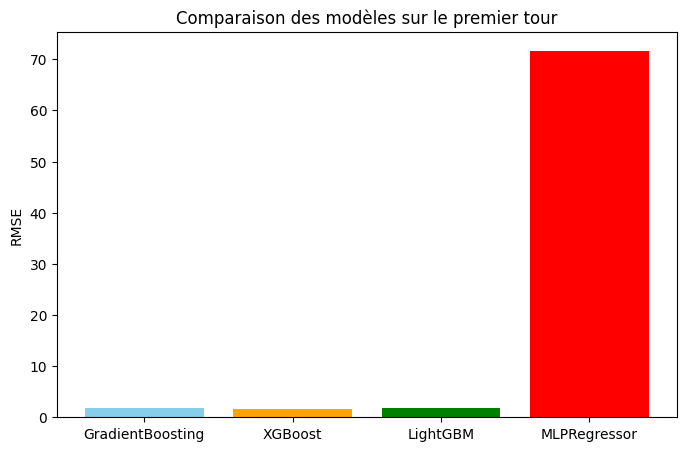

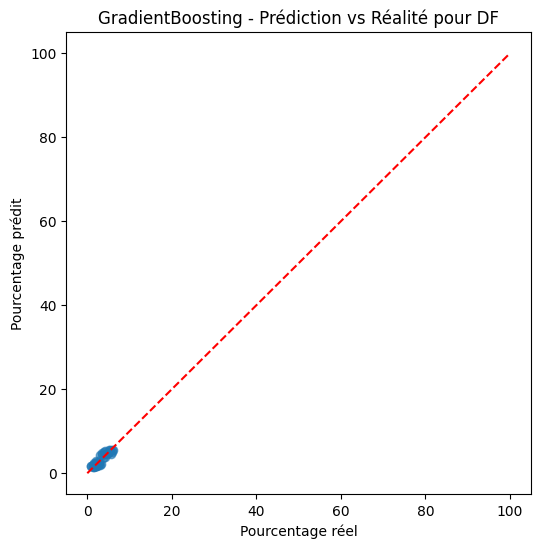

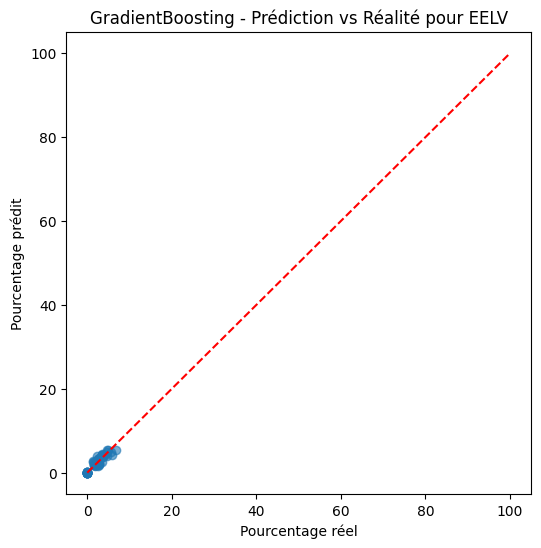

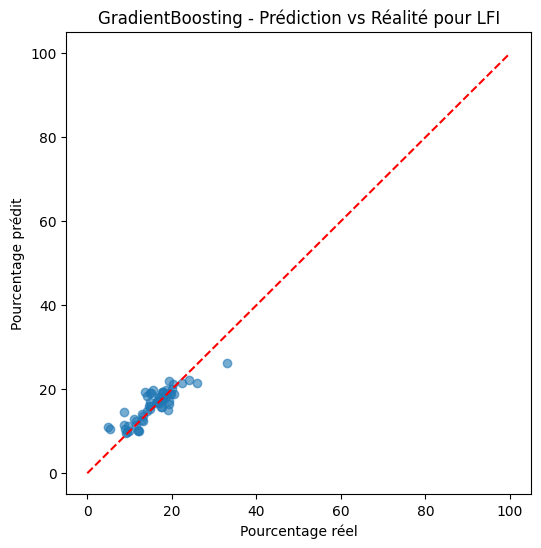

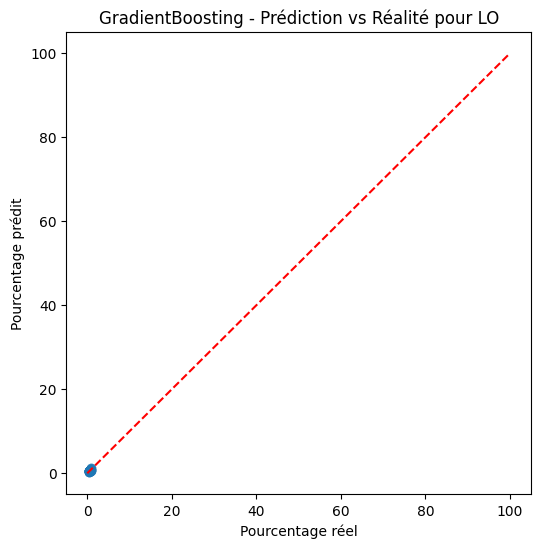

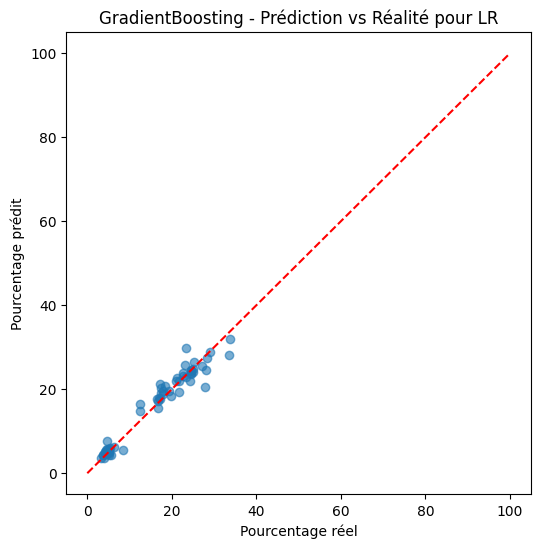

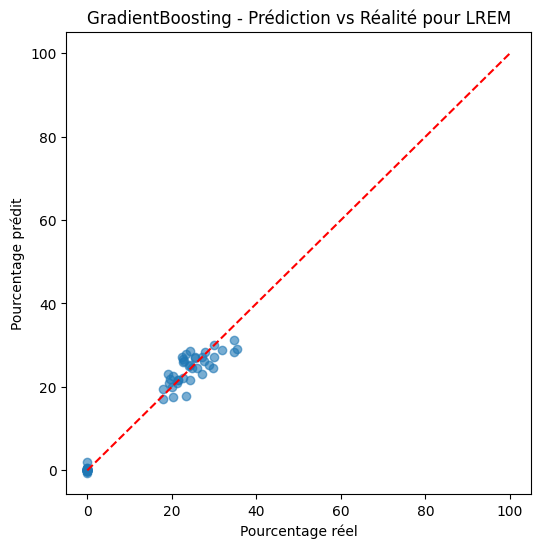

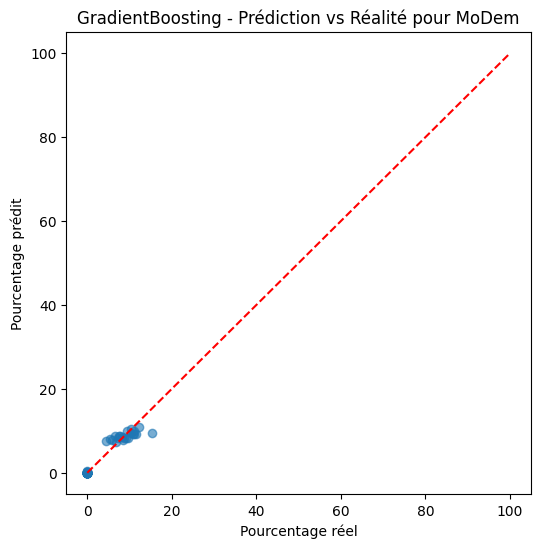

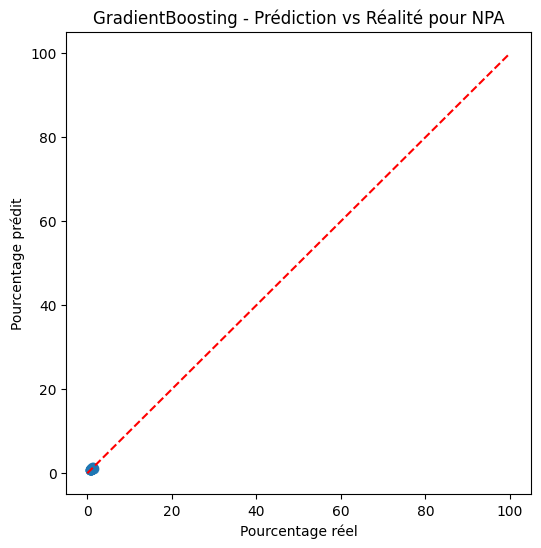

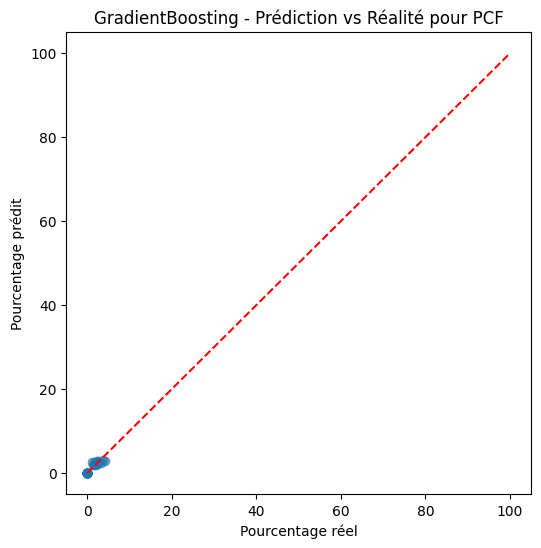

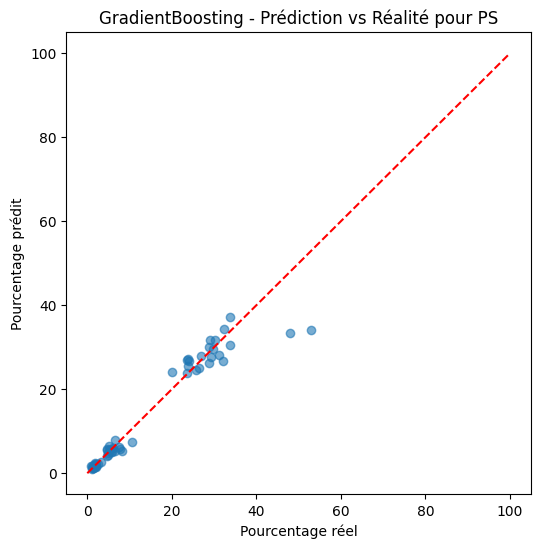

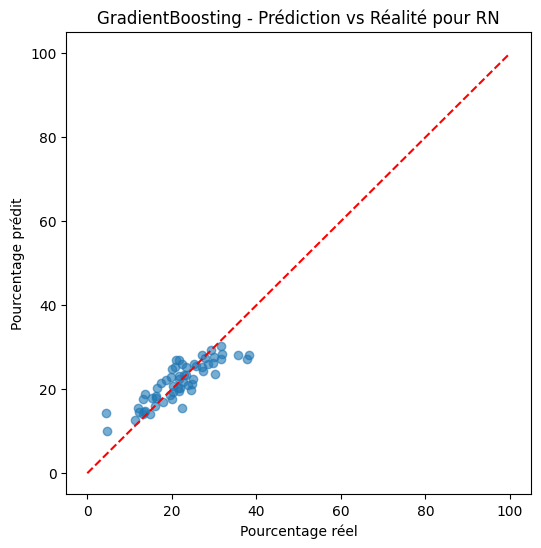

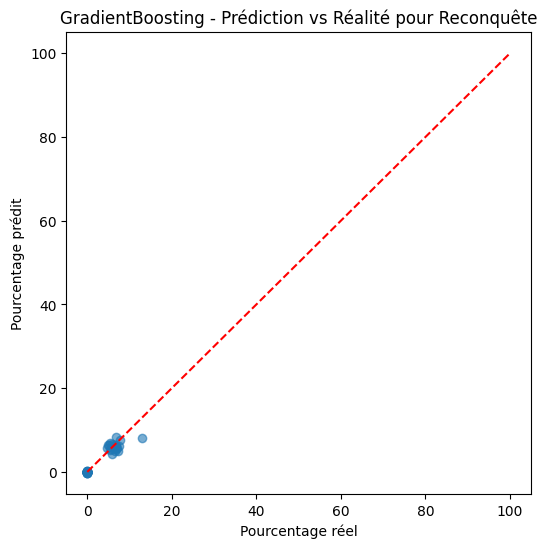

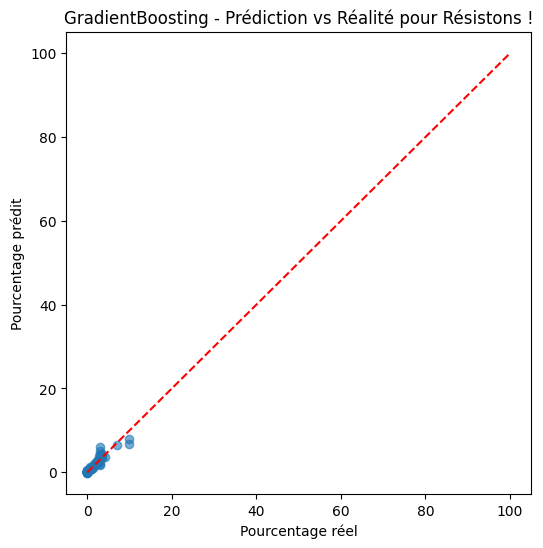

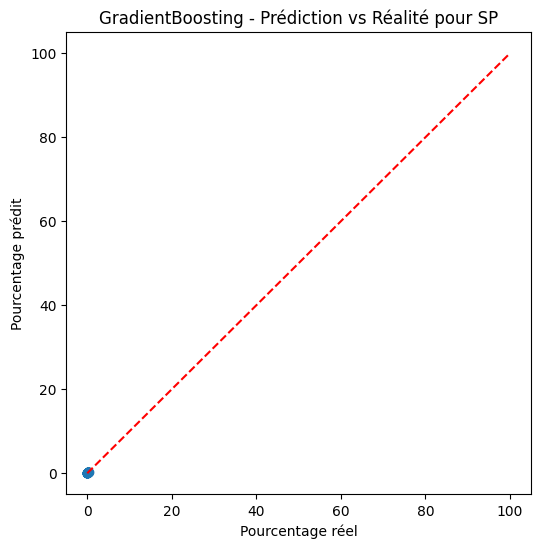

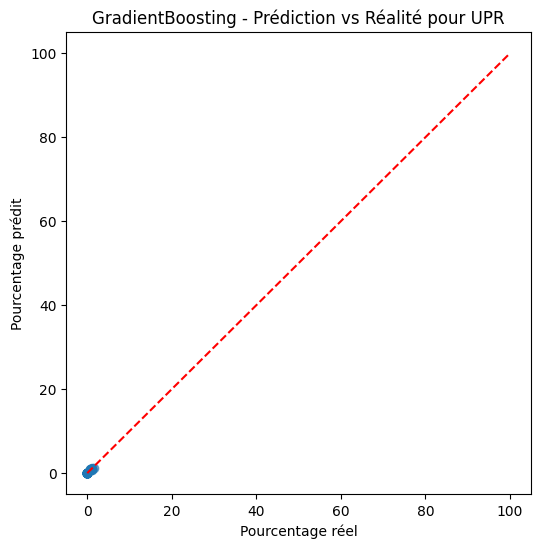

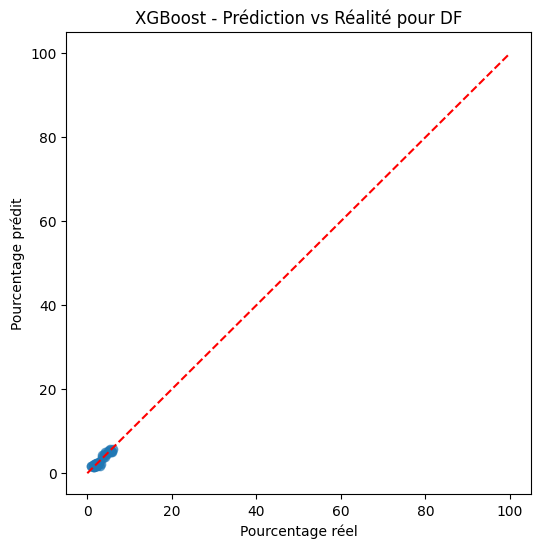

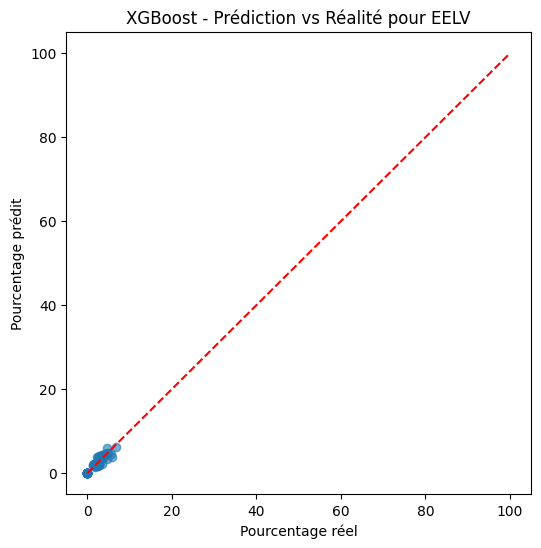

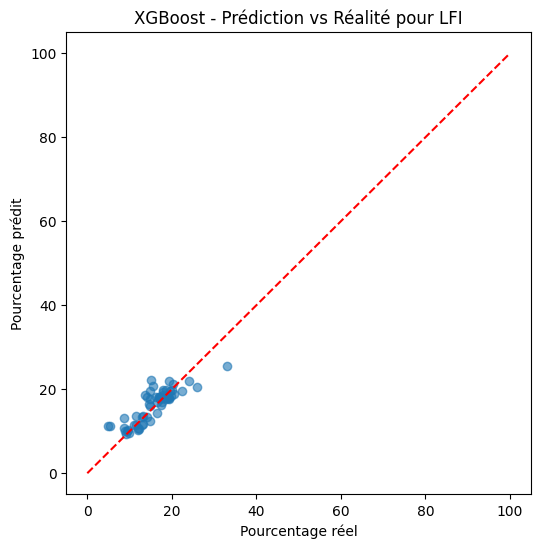

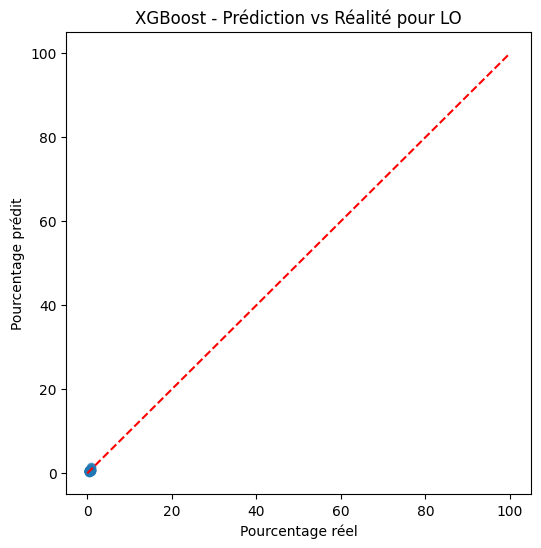

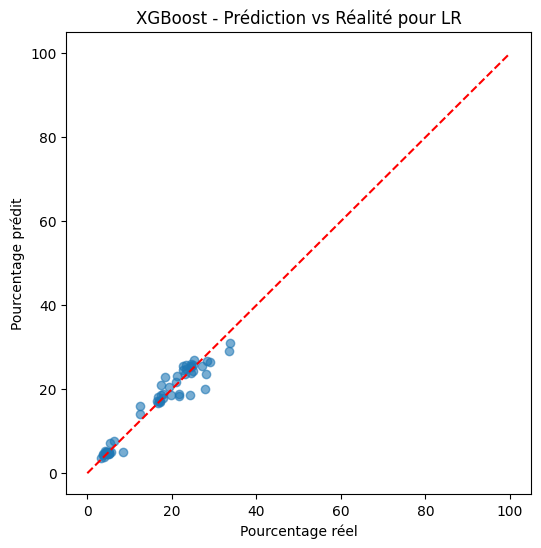

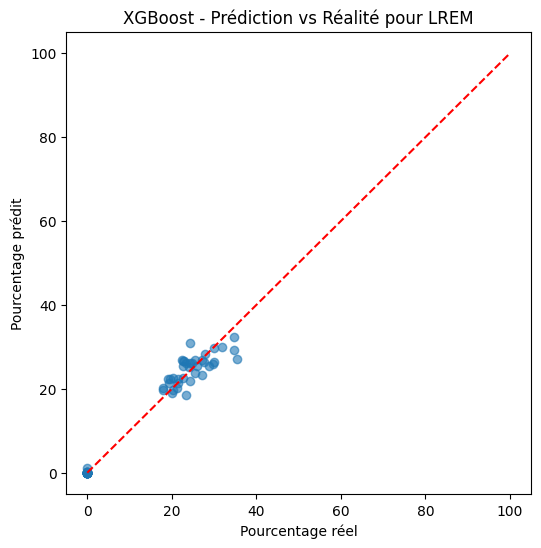

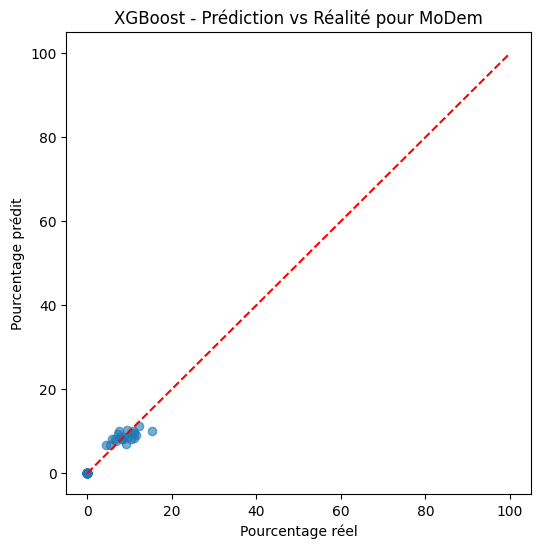

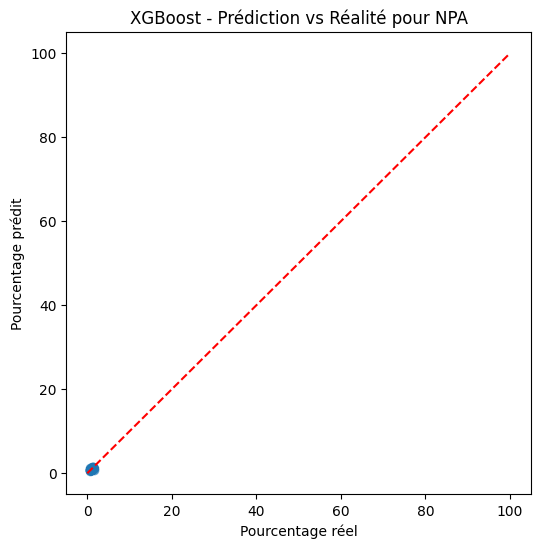

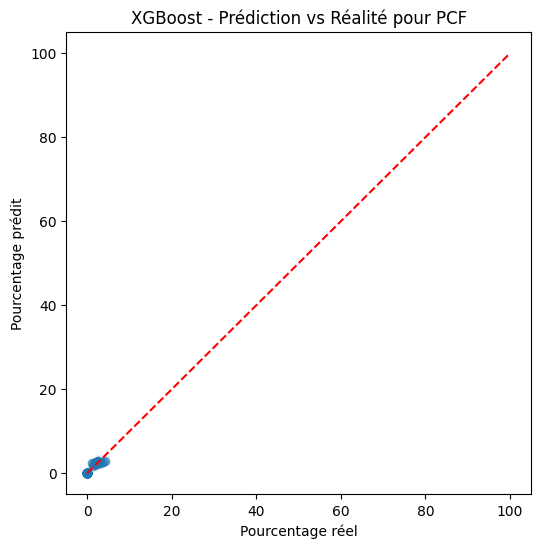

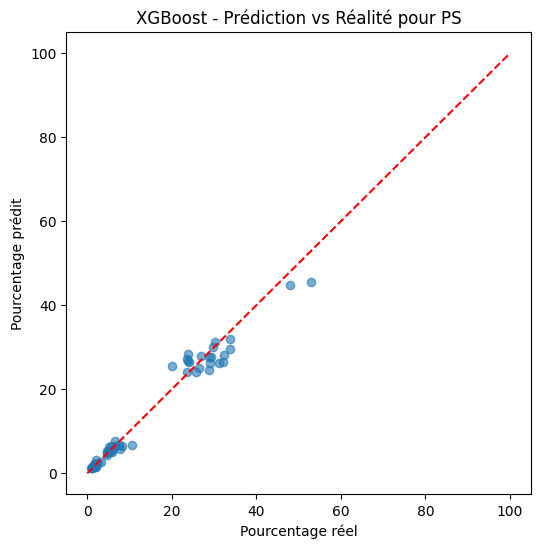

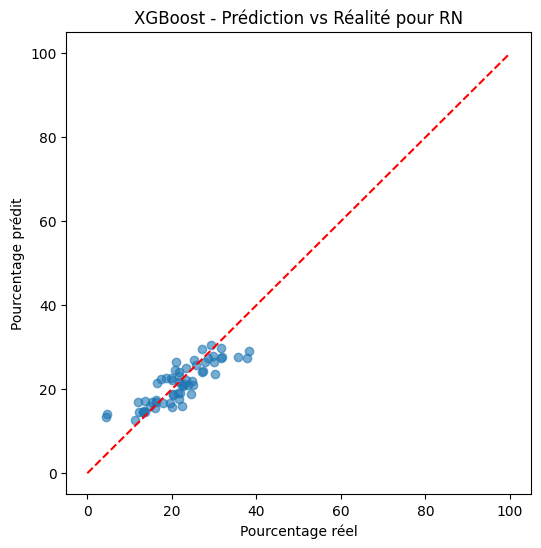

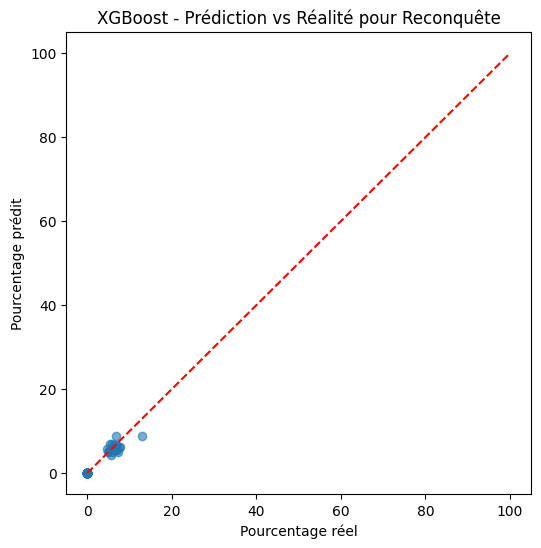

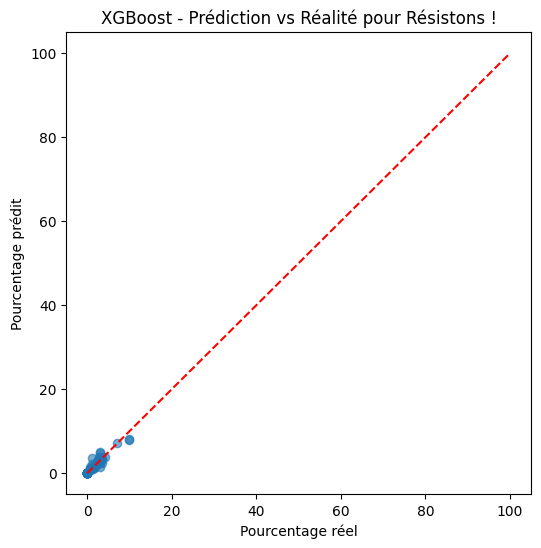

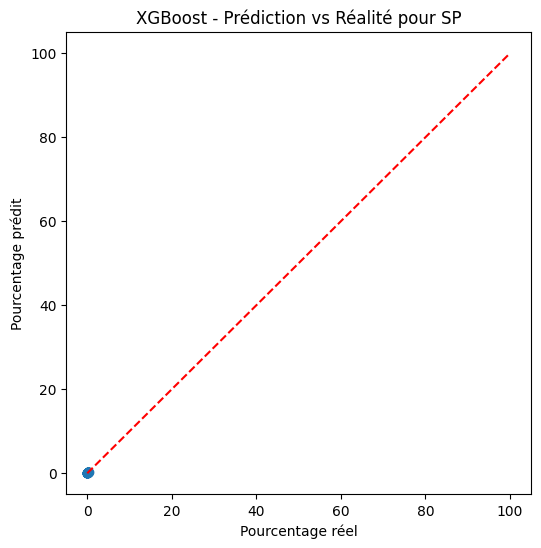

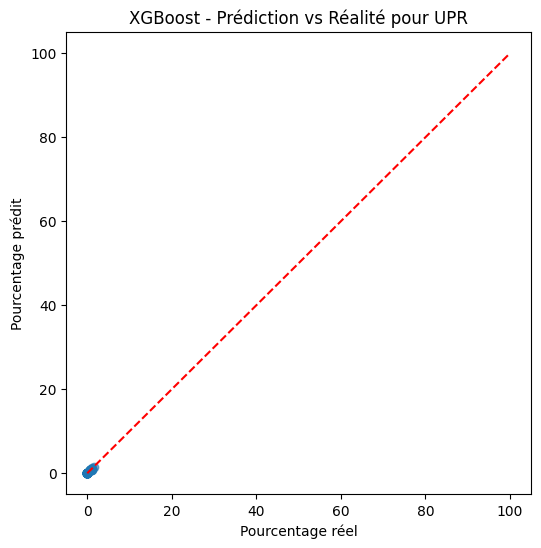

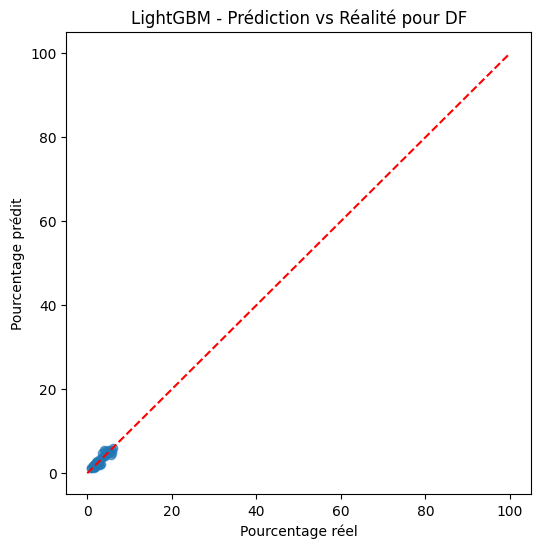

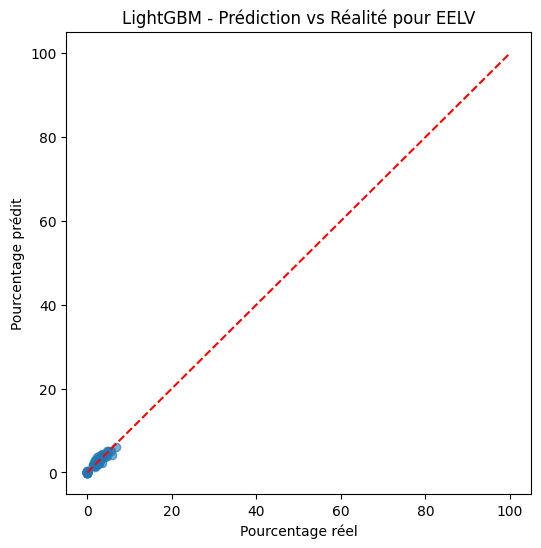

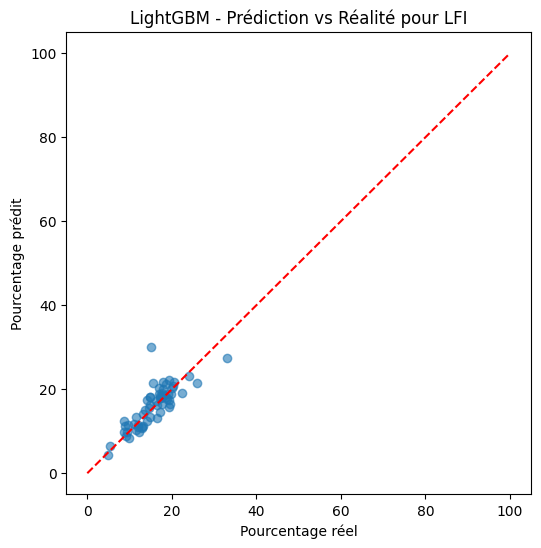

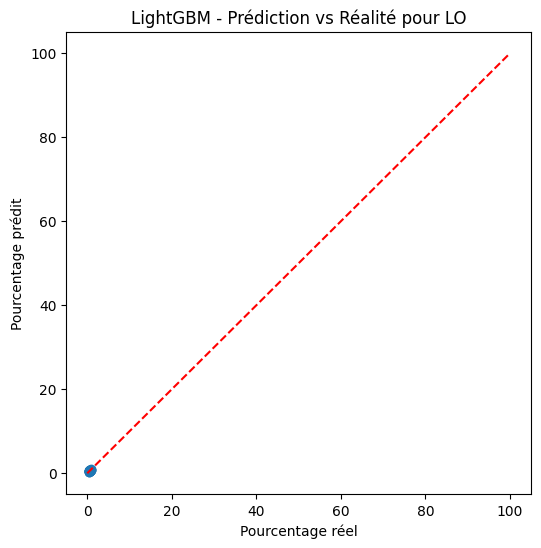

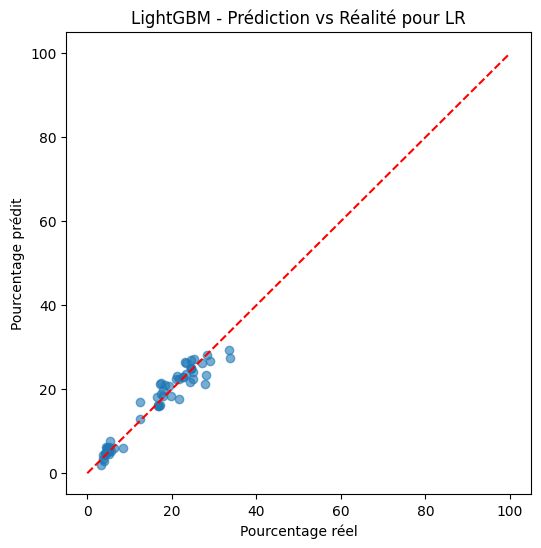

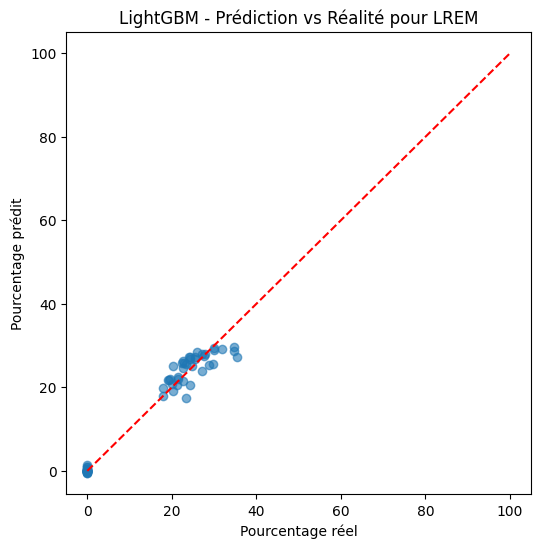

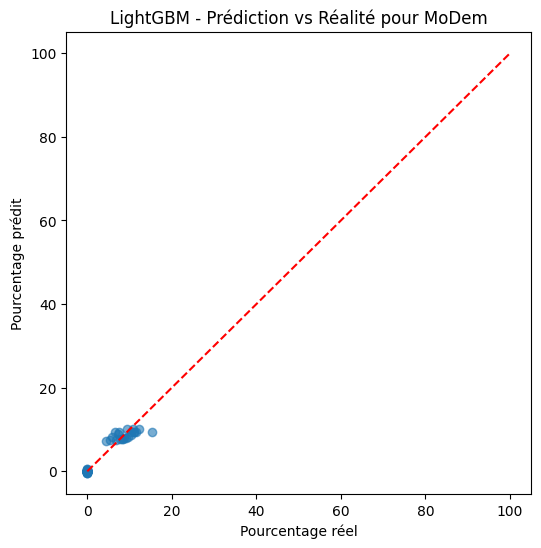

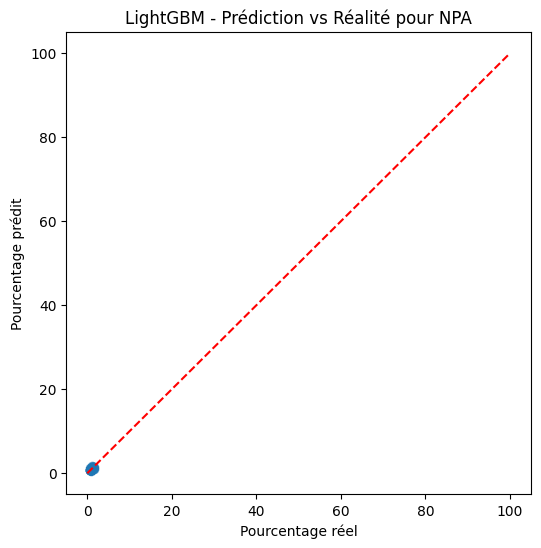

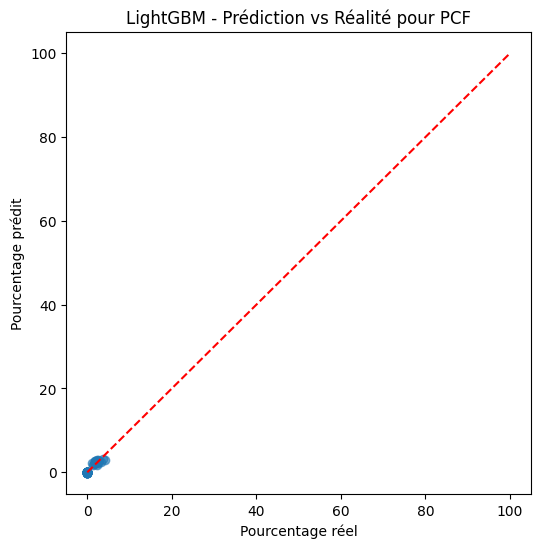

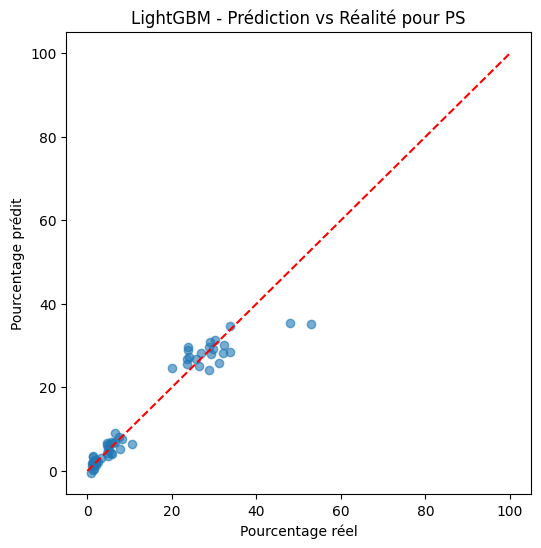

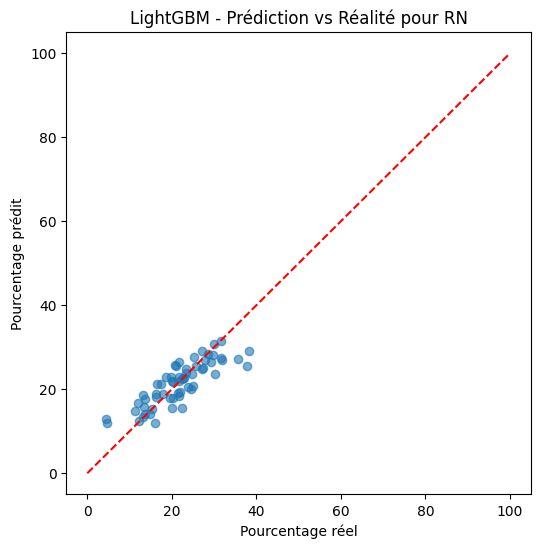

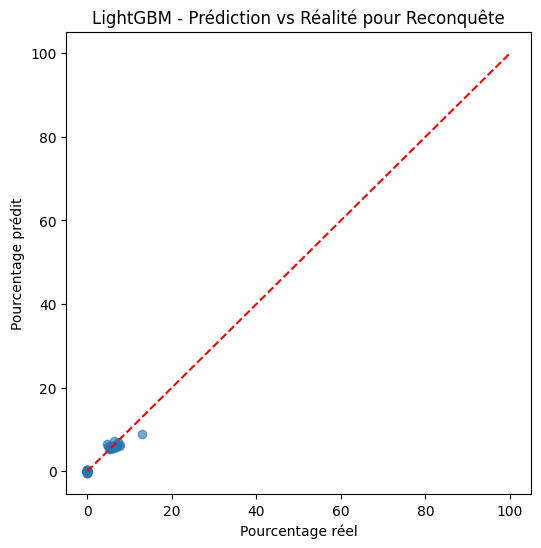

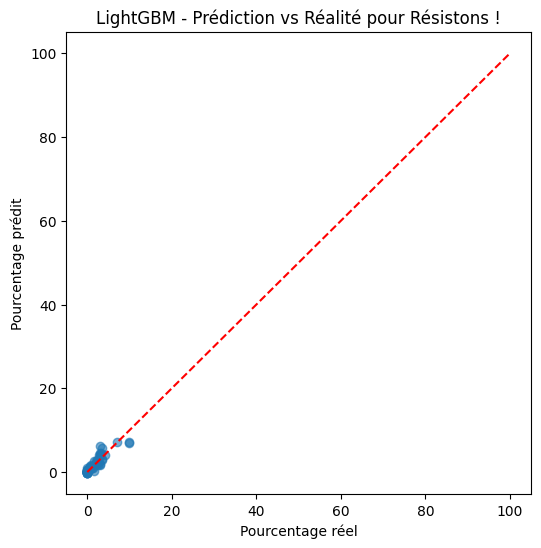

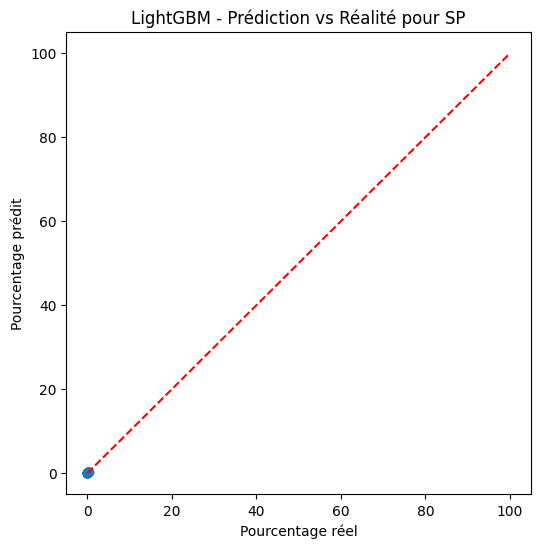

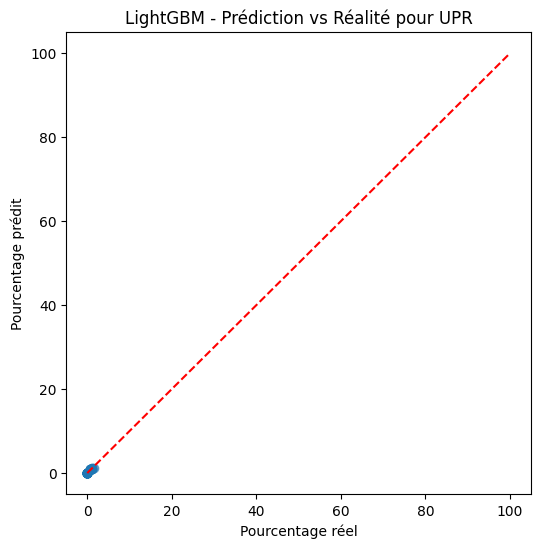

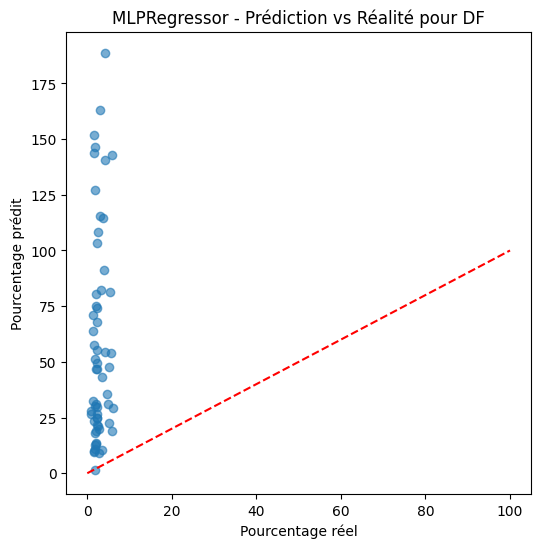

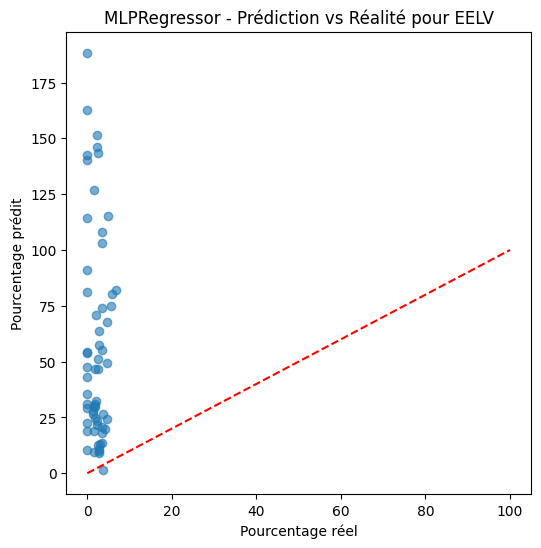

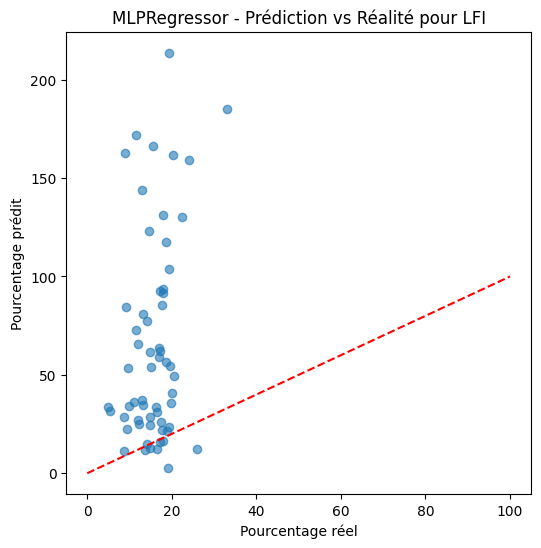

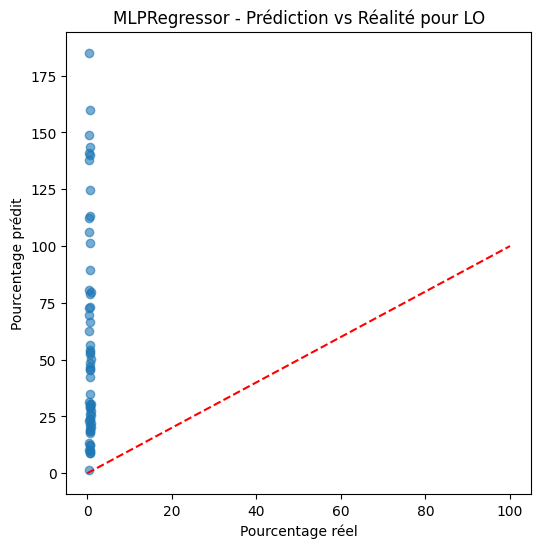

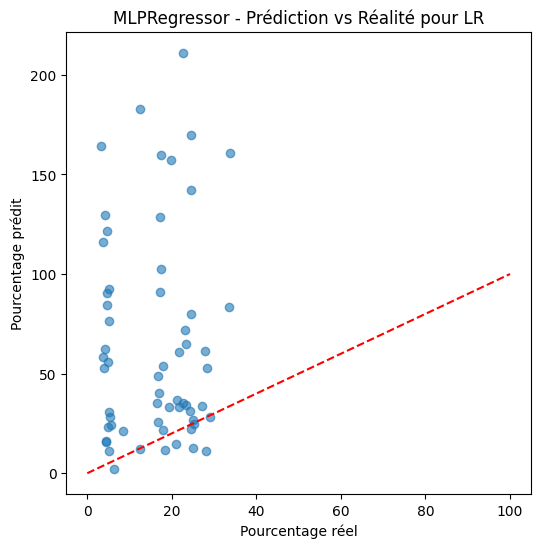

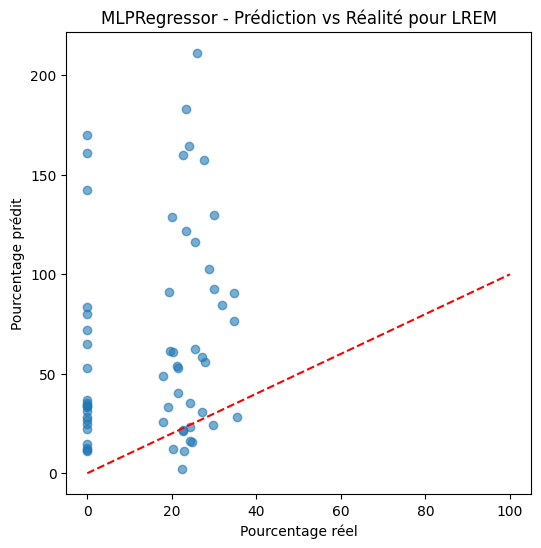

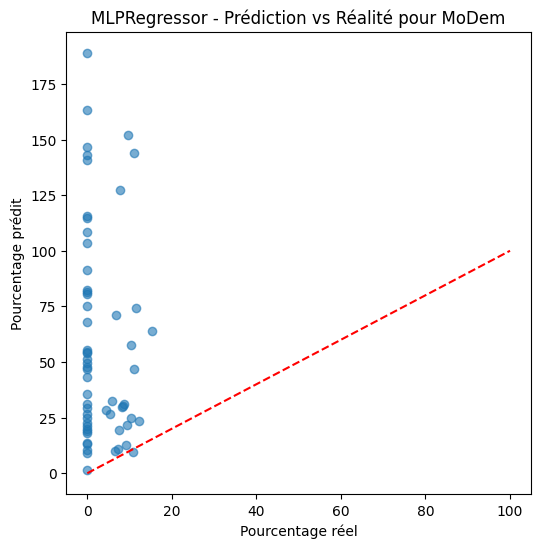

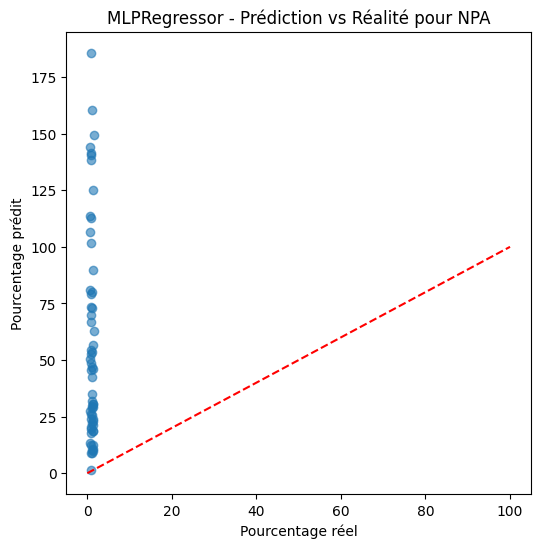

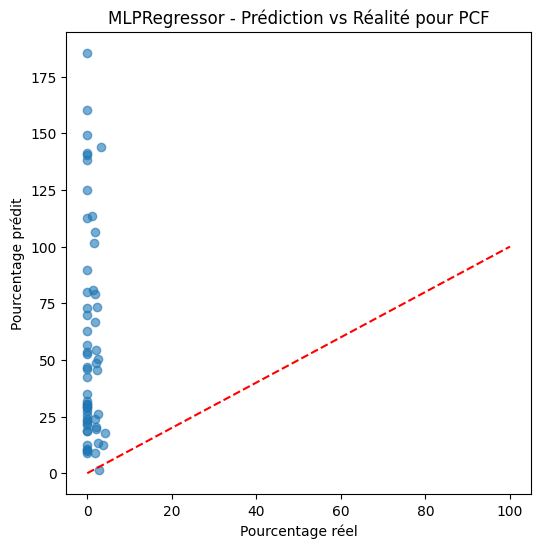

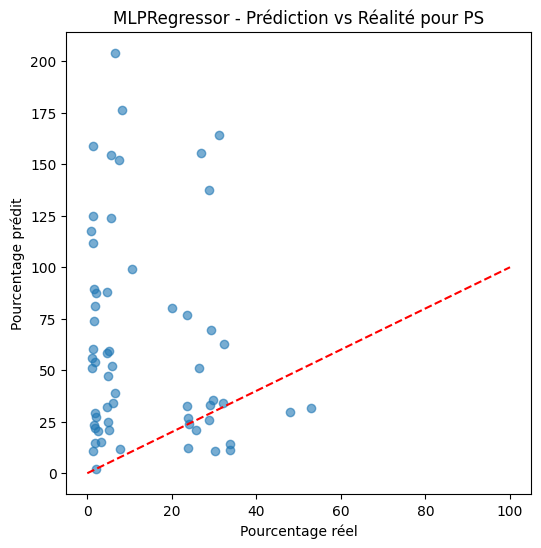

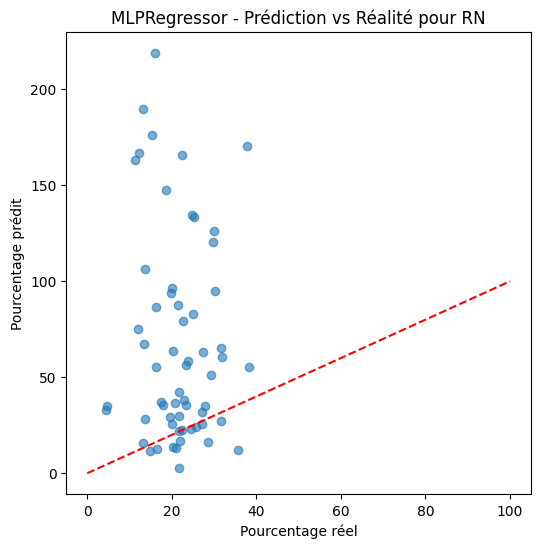

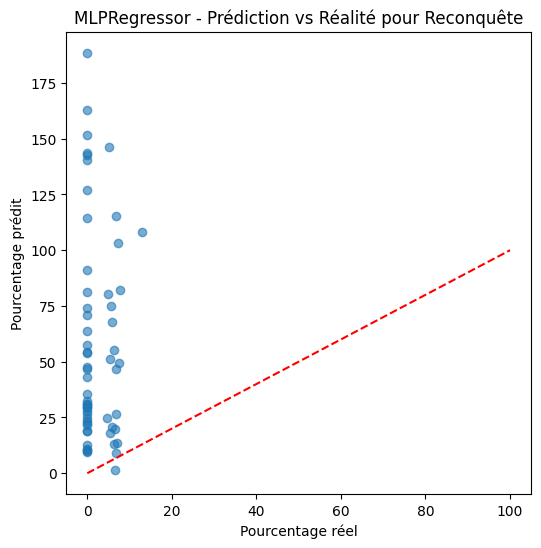

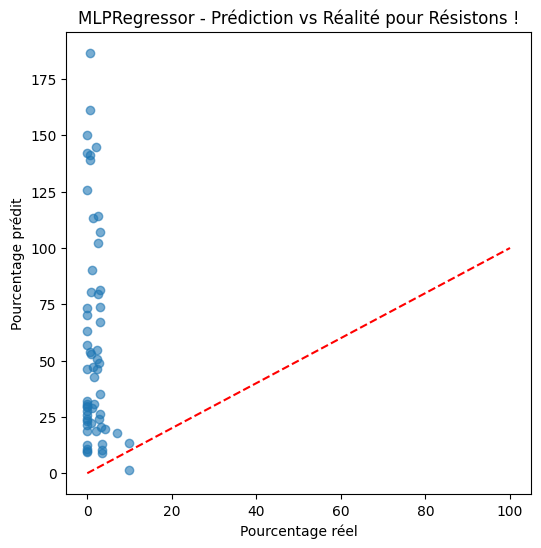

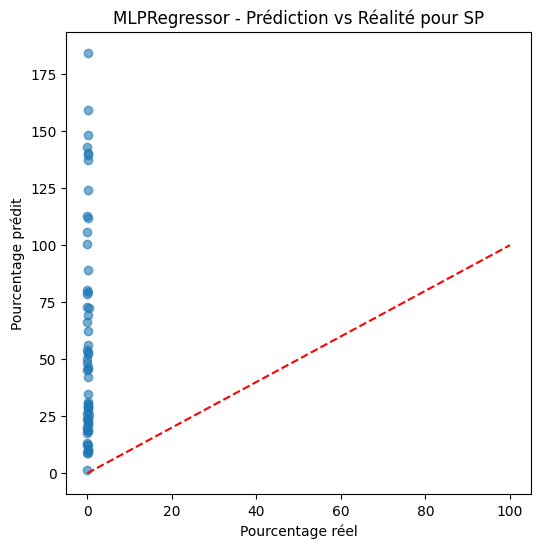

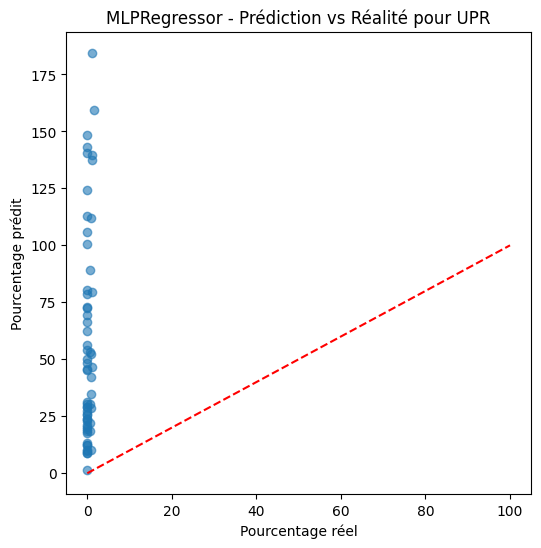

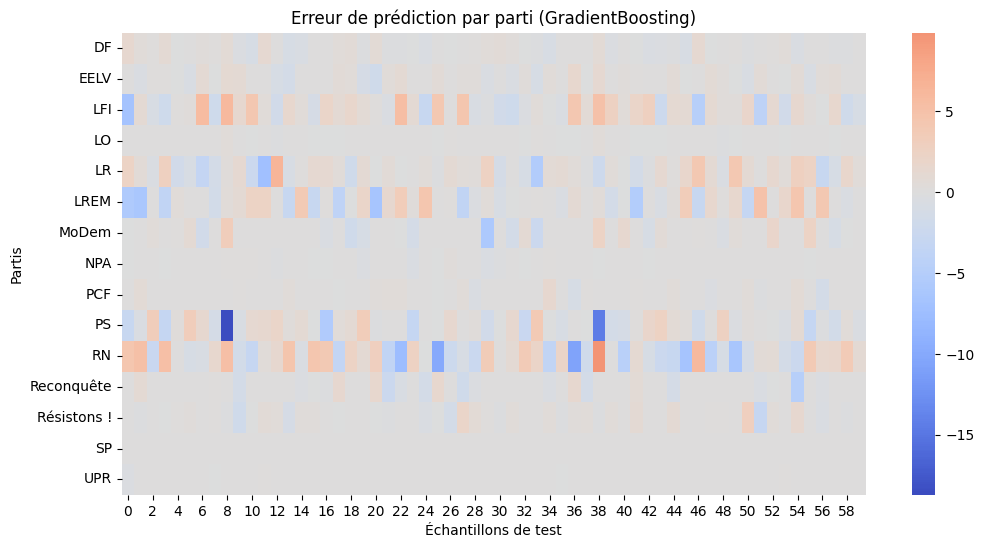

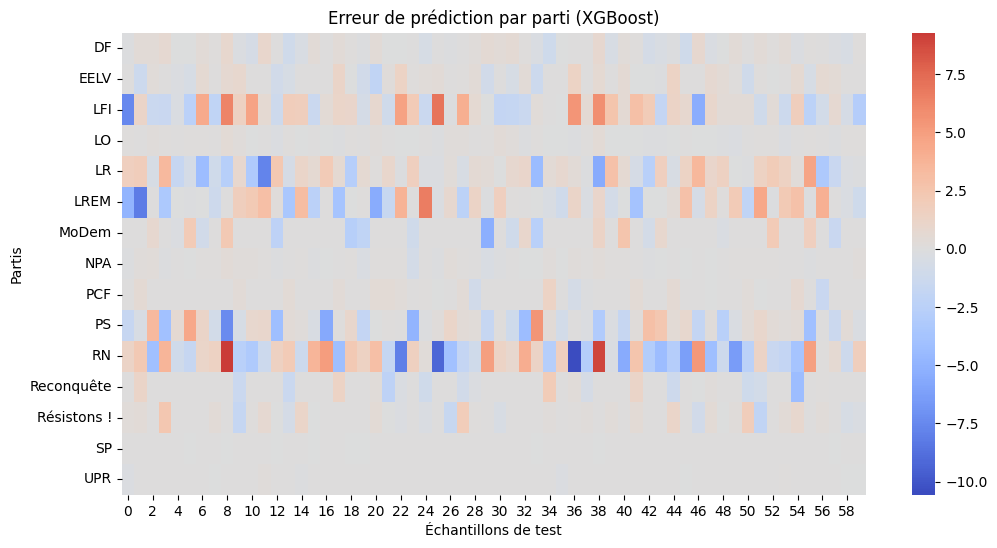

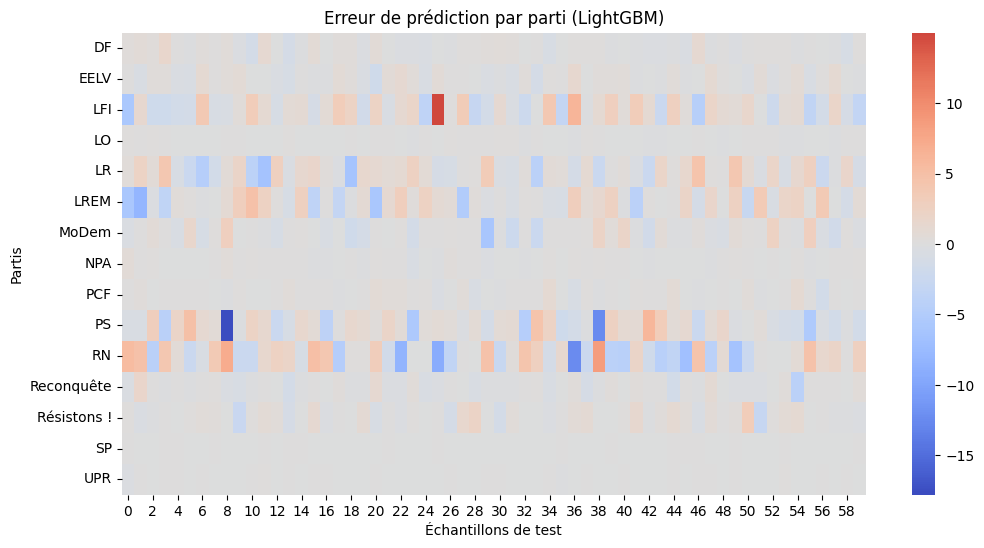

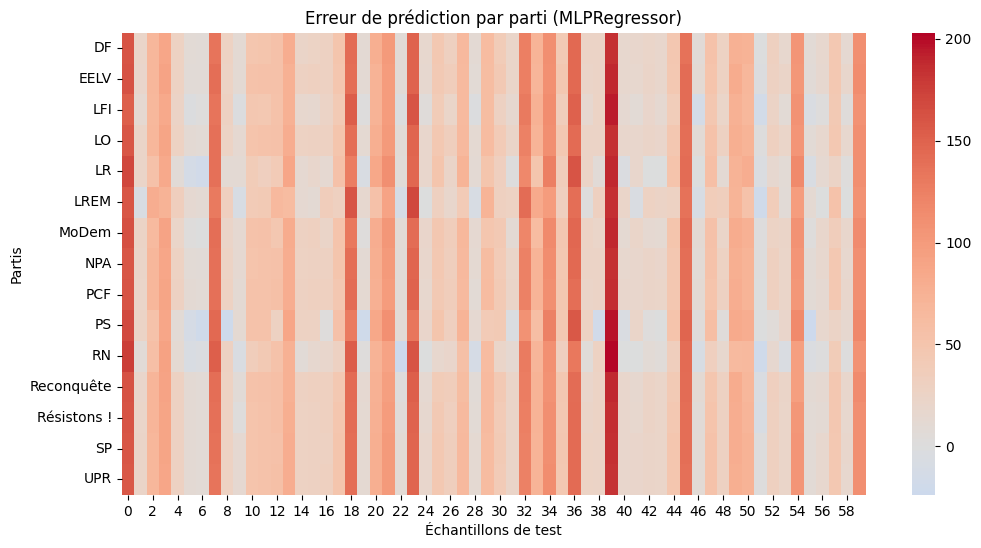

In [299]:
# %% Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
import lightgbm as lgb

# %% --- Merge des données économiques si nécessaire ---
# Supposons que df_economie contient 'annee', 'croissance_total_entreprises', 'solde_commercial'
# df_first_round sera ton df_pivot_pop filtré pour le tour 1
df_first_round = df_pivot_pop[df_pivot_pop['tour'] == 1].copy()

# %% --- Features et cible ---
partis_cols = [
    'DF', 'EELV', 'LFI', 'LO', 'LR', 'LREM', 'MoDem',
    'NPA', 'PCF', 'PS', 'RN', 'Reconquête', 'Résistons !', 'SP', 'UPR'
]

feature_cols = [
    'pct_abstentions',
    'pct_blancs_nuls',
    'population_totale',
    'pct_femmes',
    'pct_hommes',
    'pct_jeunes',
    'pct_seniors',
    'taux_chomage',
    'taux_pour_mille',
    'croissance_total_entreprises',
    'solde_commercial',
    'taux_epargne', 
    'prix_consommation', 
    'pre_depenses'
]

X = df_first_round[feature_cols]
y = df_first_round[partis_cols]

# %% --- Remplacement des NaN par la moyenne (si présents) ---
X.fillna(X.mean(), inplace=True)

# %% --- Split train/test ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# %% --- Dictionnaires pour stocker résultats et prédictions ---
results = {}
predictions = {}

# %% --- Fonction pour entraîner et évaluer un modèle ---
def train_model(name, model):
    multi_model = MultiOutputRegressor(model)
    multi_model.fit(X_train, y_train)
    y_pred = multi_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results[name] = rmse
    predictions[name] = y_pred
    print(f"{name} RMSE: {rmse:.3f}")

# %% --- Entraînement des modèles ---
train_model('GradientBoosting', GradientBoostingRegressor(n_estimators=200, random_state=42))
train_model('XGBoost', xgb.XGBRegressor(n_estimators=200, random_state=42, objective='reg:squarederror'))
train_model('LightGBM', lgb.LGBMRegressor(n_estimators=200, random_state=42))
train_model('MLPRegressor', MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42))

# %% --- Comparaison RMSE (Bar plot) ---
plt.figure(figsize=(8, 5))
plt.bar(results.keys(), results.values(), color=['skyblue', 'orange', 'green', 'red'])
plt.ylabel("RMSE")
plt.title("Comparaison des modèles sur le premier tour")
plt.show()

# %% --- Scatter plot réel vs prédit pour chaque modèle et chaque parti ---
for model_name, y_pred in predictions.items():
    for i, parti in enumerate(partis_cols):
        plt.figure(figsize=(6, 6))
        plt.scatter(y_test[parti], y_pred[:, i], alpha=0.6)
        plt.plot([0, 100], [0, 100], 'r--')
        plt.xlabel("Pourcentage réel")
        plt.ylabel("Pourcentage prédit")
        plt.title(f"{model_name} - Prédiction vs Réalité pour {parti}")
        plt.show()

# %% --- Heatmap des erreurs par modèle ---
for model_name, y_pred in predictions.items():
    errors = pd.DataFrame(y_pred, columns=partis_cols) - y_test.reset_index(drop=True)
    plt.figure(figsize=(12, 6))
    sns.heatmap(errors.T, cmap='coolwarm', center=0, annot=False)
    plt.title(f"Erreur de prédiction par parti ({model_name})")
    plt.ylabel("Partis")
    plt.xlabel("Échantillons de test")
    plt.show()
